In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
from numpy import genfromtxt
import glob

import zipfile
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from IPython.display import VimeoVideo
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [3]:
df = pd.read_excel(r'prescription_cost.xlsx')

In [4]:
df.head(5)

,BNF chemical name,Drug/device name,Drug formulation,Drug strength,Item description,BNF sub-section,BNF sub-section.1,Number of dispensed items,Dispensed quantity,Gross ingredient cost (£),Cost per item (£),Quantity per item
0,ABACAVIR,ABACAVIR,TABS,300 MG,NaN,HIV INFECTION,50301,23,1232.0,4290.44,186.540870,53.565217
1,ABACAVIR AND LAMIVUDINE,ABACAVIR AND LAMIVUDINE,TABS,NaN,600MG/300MG,HIV INFECTION,50301,24,678.0,6171.05,257.127083,28.250000
2,ABACAVIR AND LAMIVUDINE,KIVEXA,TABS,NaN,NaN,HIV INFECTION,50301,2,58.0,681.02,340.510000,29.000000
3,"ABACAVIR, LAMIVUDINE AND DOLUTEGRAVIR",TRIUMEQ,TABS,NaN,NaN,HIV INFECTION,50301,663,21120.0,561106.48,846.314449,31.855204
4,ABATACEPT,ABATACEPT,INJ,125 MG/1ML,SOLUTION FOR INJECTION PREFILLED SYRINGE,RHEUMATIC DISEASE SUPPRESSANT DRUGS,100103,1,4.0,1209.60,1209.600000,4.000000


In [5]:
df.tail(3)

,BNF chemical name,Drug/device name,Drug formulation,Drug strength,Item description,BNF sub-section,BNF sub-section.1,Number of dispensed items,Dispensed quantity,Gross ingredient cost (£),Cost per item (£),Quantity per item
11738,ZUCLOPENTHIXOL,ZUCLOPENTHIXOL DIHYDROCHLORIDE,TABS,10 MG,NaN,ANTIPSYCHOTIC DRUGS,40201,307,38200.0,3078.92,10.029055,124.429967
11739,ZUCLOPENTHIXOL,ZUCLOPENTHIXOL DIHYDROCHLORIDE,TABS,2 MG,NaN,ANTIPSYCHOTIC DRUGS,40201,175,20800.0,653.12,3.732114,118.857143
11740,ZUCLOPENTHIXOL,ZUCLOPENTHIXOL DIHYDROCHLORIDE,TABS,25 MG,NaN,ANTIPSYCHOTIC DRUGS,40201,126,15500.0,2500.15,19.842460,123.015873


In [6]:
df.shape

(11741, 12)

Dropping rows that are empty in both the drug strength column and the item description column.

we dropped the rows that are empty in both drug strength column and the item description column, so as to know the total drugs that has drug strength.

In [7]:
df = df.dropna(subset=['Drug strength', 'Item description'], how='all')

In [8]:
df.head()

,BNF chemical name,Drug/device name,Drug formulation,Drug strength,Item description,BNF sub-section,BNF sub-section.1,Number of dispensed items,Dispensed quantity,Gross ingredient cost (£),Cost per item (£),Quantity per item
0,ABACAVIR,ABACAVIR,TABS,300 MG,NaN,HIV INFECTION,50301,23,1232.0,4290.44,186.540870,53.565217
1,ABACAVIR AND LAMIVUDINE,ABACAVIR AND LAMIVUDINE,TABS,NaN,600MG/300MG,HIV INFECTION,50301,24,678.0,6171.05,257.127083,28.250000
4,ABATACEPT,ABATACEPT,INJ,125 MG/1ML,SOLUTION FOR INJECTION PREFILLED SYRINGE,RHEUMATIC DISEASE SUPPRESSANT DRUGS,100103,1,4.0,1209.60,1209.600000,4.000000
5,ABATACEPT,ORENCIA,INJ,125 MG/1ML,SOLUTION FOR INJECTION PREFILLED PEN,RHEUMATIC DISEASE SUPPRESSANT DRUGS,100103,1,1.0,302.40,302.400000,1.000000
6,ABIRATERONE,ABIRATERONE,TABS,500 MG,NaN,HORMONE ANTAGONISTS,80304,7920,438990.0,21389480.55,2700.691989,55.428030


In [9]:
df.shape

(10244, 12)

After dropping cells with empty cells n both drug strength and item description the total entries is 10244

# Removing the non-drug rows using the drug formulation columns.

We realized that there are some drugs that has no drug strength in both the drug strength column and item description column (to put it simple there are some names in the BNF chemical name column that are not drug for example: cotton), so we need to drop them for better result.

To do that we need to know the types of drug in the drug formulation column.

In [10]:
df["Drug formulation"].unique()

array(['TABS', 'INJ', nan, 'CAPS', 'SPRAY', 'DROPS', 'CREAM', 'OINT',
       'SUSP', 'INHAL', 'GEL', 'SOLN', 'LOT', 'APPL', 'SYRUP', 'SACH',
       'SOL', 'LOZ', 'OIL', 'TINCT', 'INF', 'LIQ', 'SUPPS', 'FOAM',
       'ENEMA', 'PATCH', 'PDR', 'VACC', 'LINCT', 'SHAMP', 'EMULS',
       'GRANS', 'MIXT', 'ELIX', 'TUBES', 'PESS', 'FILM', 'CRYST', 'AMPS',
       'RUB', 'GUM', 'WATER', 'SCRUB', 'PAINT', 'RINSE'], dtype=object)

In [11]:
drug_formulations = ['TABS', 'INJ', 'CAPS', 'SPRAY', 'DROPS', 'CREAM', 'OINT', 'SUSP', 'INHAL', 'GEL', 'SOLN', 'LOT', 'APPL', 'SYRUP',
                     'SACH', 'SOL', 'LOZ', 'OIL', 'TINCT', 'INF', 'LIQ', 'SUPPS', 'FOAM', 'ENEMA', 'PATCH', 'PDR', 'VACC', 'LINCT',
                     'SHAMP', 'EMULS', 'GRANS', 'MIXT', 'ELIX', 'TUBES', 'PESS', 'FILM', 'CRYST', 'AMPS', 'RUB', 'GUM', 'WATER',
                     'SCRUB', 'PAINT', 'RINSE']

# Remove rows where drug formulation is not in the list
df = df[df['Drug formulation'].isin(drug_formulations)]
df.head(2)

,BNF chemical name,Drug/device name,Drug formulation,Drug strength,Item description,BNF sub-section,BNF sub-section.1,Number of dispensed items,Dispensed quantity,Gross ingredient cost (£),Cost per item (£),Quantity per item
0,ABACAVIR,ABACAVIR,TABS,300 MG,NaN,HIV INFECTION,50301,23,1232.0,4290.44,186.540870,53.565217
1,ABACAVIR AND LAMIVUDINE,ABACAVIR AND LAMIVUDINE,TABS,NaN,600MG/300MG,HIV INFECTION,50301,24,678.0,6171.05,257.127083,28.250000


In [12]:
df.shape

(6515, 12)

# Merge the drug strength column with the item description column

After dropping the non-drugs we have the total of 6515 enteries in the dataset.

Merging the drug strength columns with the item description columns and drop unnecessary cells in the item description column.

In [13]:
# Merge columns and drop unnecessary columns
df['merged_info'] = df['Drug strength'].fillna(df['Item description'])

To further simplify the dataset, drugs that appear to be drug mixtures will be splitted and placed in a new column while the non drug mixtures will be in their existing columns


In [14]:
df[['BNF_chemical_name(1)', 'BNF_chemical_name(2)']] = df['BNF chemical name'].str.split(' AND|WITH', 1, expand=True)
df["drug_strength(1)"] = df["merged_info"].str.split("/", expand = True)[0]
df["drug_strength(2)"] = df["merged_info"].str.split("/", expand = True)[1]

C:\Users\HP\AppData\Local\Temp\ipykernel_3232\2395997371.py:1: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['BNF_chemical_name(1)', 'BNF_chemical_name(2)']] = df['BNF chemical name'].str.split(' AND|WITH', 1, expand=True)


In [15]:
df.head(8)

,BNF chemical name,Drug/device name,Drug formulation,Drug strength,Item description,BNF sub-section,BNF sub-section.1,Number of dispensed items,Dispensed quantity,Gross ingredient cost (£),Cost per item (£),Quantity per item,merged_info,BNF_chemical_name(1),BNF_chemical_name(2),drug_strength(1),drug_strength(2)
0,ABACAVIR,ABACAVIR,TABS,300 MG,NaN,HIV INFECTION,50301,23,1232.0,4290.44,186.540870,53.565217,300 MG,ABACAVIR,None,300 MG,None
1,ABACAVIR AND LAMIVUDINE,ABACAVIR AND LAMIVUDINE,TABS,NaN,600MG/300MG,HIV INFECTION,50301,24,678.0,6171.05,257.127083,28.250000,600MG/300MG,ABACAVIR,LAMIVUDINE,600MG,300MG
4,ABATACEPT,ABATACEPT,INJ,125 MG/1ML,SOLUTION FOR INJECTION PREFILLED SYRINGE,RHEUMATIC DISEASE SUPPRESSANT DRUGS,100103,1,4.0,1209.60,1209.600000,4.000000,125 MG/1ML,ABATACEPT,None,125 MG,1ML
5,ABATACEPT,ORENCIA,INJ,125 MG/1ML,SOLUTION FOR INJECTION PREFILLED PEN,RHEUMATIC DISEASE SUPPRESSANT DRUGS,100103,1,1.0,302.40,302.400000,1.000000,125 MG/1ML,ABATACEPT,None,125 MG,1ML
6,ABIRATERONE,ABIRATERONE,TABS,500 MG,NaN,HORMONE ANTAGONISTS,80304,7920,438990.0,21389480.55,2700.691989,55.428030,500 MG,ABIRATERONE,None,500 MG,None
7,ABIRATERONE,ZYTIGA,TABS,500 MG,NaN,HORMONE ANTAGONISTS,80304,176,9793.0,478283.13,2717.517784,55.642045,500 MG,ABIRATERONE,None,500 MG,None
10,ACAMPROSATE CALCIUM,ACAMPROSATE CALCIUM,TABS,333 MG,EC,ALCOHOL DEPENDENCE,41001,19983,3252506.0,730319.86,36.547058,162.763649,333 MG,ACAMPROSATE CALCIUM,None,333 MG,None
11,ACAMPROSATE CALCIUM,CAMPRAL,TABS,333 MG,EC,ALCOHOL DEPENDENCE,41001,14720,2424982.0,410688.35,27.900024,164.740625,333 MG,ACAMPROSATE CALCIUM,None,333 MG,None


In [16]:
df.shape

(6515, 17)

We create new columns in the dataset, bnf chemical name(1), bnf chemical name(2), drug strength(1) and drug strength (2). for the splitted drugs with there drug strength respectively.

Conversion of drug strength measured in grams to grams

In [17]:
import re
import numpy as np
def extract_mg_value(value):
    if pd.notna(value):
        # Extract numerical value followed by "G"
        g_match = re.search(r'(\d+\.?\d*)\s*(G)', value, re.IGNORECASE)
        if g_match:
            return float(g_match.group(1))
        # Extract numerical value followed by "MG" (miligrams)
        mg_match = re.search(r'(\d+\.?\d*)\s*(MG)', value, re.IGNORECASE)
        if mg_match:
            return float(mg_match.group(1)) / 1000 # Convert miligrams to grams

        # Extract numerical value followed by "MCG" (micrograms)
        mcg_match = re.search(r'(\d+\.?\d*)\s*(MCG)', value, re.IGNORECASE)
        if mcg_match:
            return float(mcg_match.group(1)) / 1000000.0  # Convert micrograms to grams
        nan_match = re.search(r'(\d+\.?\d*)\s*(NANOGRAMS)', value, re.IGNORECASE)
        if nan_match:
            return float(nan_match.group(1)) / 1000000000.0
        # Extract numerical value followed by "MCG" (micrograms)
        mcg_match = re.search(r'(\d+\.?\d*)\s*(MICROGRAMS)', value, re.IGNORECASE)
        if mcg_match:
            return float(mcg_match.group(1)) / 1000000.0  # Convert micrograms to grams


        # If none of the patterns match, return NaN
        return np.nan

# Apply the extract_mg_value function to the 'Value' column to get the mg values
df['Drug_strength(1)(g)'] = df['drug_strength(1)'].apply(extract_mg_value)
df['Drug_strength(2)(g)'] = df['drug_strength(2)'].apply(extract_mg_value)

Dropping cells has are empty in both drug strength 1 and drug strength 2. But if one of the column has a value do not drop

In [18]:
df = df.dropna(subset=['Drug_strength(1)(g)', 'Drug_strength(2)(g)'], how='all')

In [19]:
df.shape

(5182, 19)

In [20]:
df.head()

,BNF chemical name,Drug/device name,Drug formulation,Drug strength,Item description,BNF sub-section,BNF sub-section.1,Number of dispensed items,Dispensed quantity,Gross ingredient cost (£),Cost per item (£),Quantity per item,merged_info,BNF_chemical_name(1),BNF_chemical_name(2),drug_strength(1),drug_strength(2),Drug_strength(1)(g),Drug_strength(2)(g)
0,ABACAVIR,ABACAVIR,TABS,300 MG,NaN,HIV INFECTION,50301,23,1232.0,4290.44,186.540870,53.565217,300 MG,ABACAVIR,None,300 MG,None,0.300,NaN
1,ABACAVIR AND LAMIVUDINE,ABACAVIR AND LAMIVUDINE,TABS,NaN,600MG/300MG,HIV INFECTION,50301,24,678.0,6171.05,257.127083,28.250000,600MG/300MG,ABACAVIR,LAMIVUDINE,600MG,300MG,0.600,0.3
4,ABATACEPT,ABATACEPT,INJ,125 MG/1ML,SOLUTION FOR INJECTION PREFILLED SYRINGE,RHEUMATIC DISEASE SUPPRESSANT DRUGS,100103,1,4.0,1209.60,1209.600000,4.000000,125 MG/1ML,ABATACEPT,None,125 MG,1ML,0.125,NaN
5,ABATACEPT,ORENCIA,INJ,125 MG/1ML,SOLUTION FOR INJECTION PREFILLED PEN,RHEUMATIC DISEASE SUPPRESSANT DRUGS,100103,1,1.0,302.40,302.400000,1.000000,125 MG/1ML,ABATACEPT,None,125 MG,1ML,0.125,NaN
6,ABIRATERONE,ABIRATERONE,TABS,500 MG,NaN,HORMONE ANTAGONISTS,80304,7920,438990.0,21389480.55,2700.691989,55.428030,500 MG,ABIRATERONE,None,500 MG,None,0.500,NaN


Conversion of drug strength measured in grams to kilogram

In [21]:
def extract_mg_value(value):
    if pd.notna(value):
        # Extract numerical value followed by "KG"
        kg_match = re.search(r'(\d+\.?\d*)\s*(KG)', value, re.IGNORECASE)
        if kg_match:
            return float(kg_match.group(1))
        g_match = re.search(r'(\d+\.?\d*)\s*(G)', value, re.IGNORECASE)
        if g_match:
            return float(g_match.group(1)) / 1000
        mg_match = re.search(r'(\d+\.?\d*)\s*(MG)', value, re.IGNORECASE)
        if mg_match:
            return float(mg_match.group(1)) / 1000000

        # Extract numerical value followed by "MCG" (micrograms)
        mcg_match = re.search(r'(\d+\.?\d*)\s*(MCG)', value, re.IGNORECASE)
        if mcg_match:
            return float(mcg_match.group(1)) / 1000000000.0  # Convert micrograms to kg
        # Extract numerical value followed by "MCG" (micrograms)
        mcg_match = re.search(r'(\d+\.?\d*)\s*(MICROGRAMS)', value, re.IGNORECASE)
        if mcg_match:
            return float(mcg_match.group(1)) / 1000000000.0  # Convert micrograms to kg

        nan_match = re.search(r'(\d+\.?\d*)\s*(NANOGRAMS)', value, re.IGNORECASE)
        if nan_match:
            return float(nan_match.group(1)) / 1000000000000.0


        # If none of the patterns match, return NaN
        return np.nan

# Apply the extract_mg_value function to the 'Value' column to get the mg values
df['Drug_strength(1)(kg)'] = df['drug_strength(1)'].apply(extract_mg_value)
df['Drug_strength(2)(kg)'] = df['drug_strength(2)'].apply(extract_mg_value)

Calcalate the consumed drug by multiplying drug strength with dispensed quatities

In [22]:
df["consumed_drug_1(kg)"] = df["Drug_strength(1)(kg)"] * df["Dispensed quantity"]
df["consumed_drug_2(kg)"] = df["Drug_strength(2)(kg)"] * df["Dispensed quantity"]

In [23]:
df.head(20)

,BNF chemical name,Drug/device name,Drug formulation,Drug strength,Item description,BNF sub-section,BNF sub-section.1,Number of dispensed items,Dispensed quantity,Gross ingredient cost (£),...,BNF_chemical_name(1),BNF_chemical_name(2),drug_strength(1),drug_strength(2),Drug_strength(1)(g),Drug_strength(2)(g),Drug_strength(1)(kg),Drug_strength(2)(kg),consumed_drug_1(kg),consumed_drug_2(kg)
0,ABACAVIR,ABACAVIR,TABS,300 MG,NaN,HIV INFECTION,50301,23,1232.0,4290.44,...,ABACAVIR,None,300 MG,None,0.300,NaN,0.000300,NaN,0.369600,NaN
1,ABACAVIR AND LAMIVUDINE,ABACAVIR AND LAMIVUDINE,TABS,NaN,600MG/300MG,HIV INFECTION,50301,24,678.0,6171.05,...,ABACAVIR,LAMIVUDINE,600MG,300MG,0.600,0.3,0.000600,0.0003,0.406800,0.2034
4,ABATACEPT,ABATACEPT,INJ,125 MG/1ML,SOLUTION FOR INJECTION PREFILLED SYRINGE,RHEUMATIC DISEASE SUPPRESSANT DRUGS,100103,1,4.0,1209.60,...,ABATACEPT,None,125 MG,1ML,0.125,NaN,0.000125,NaN,0.000500,NaN
5,ABATACEPT,ORENCIA,INJ,125 MG/1ML,SOLUTION FOR INJECTION PREFILLED PEN,RHEUMATIC DISEASE SUPPRESSANT DRUGS,100103,1,1.0,302.40,...,ABATACEPT,None,125 MG,1ML,0.125,NaN,0.000125,NaN,0.000125,NaN
6,ABIRATERONE,ABIRATERONE,TABS,500 MG,NaN,HORMONE ANTAGONISTS,80304,7920,438990.0,21389480.55,...,ABIRATERONE,None,500 MG,None,0.500,NaN,0.000500,NaN,219.495000,NaN
7,ABIRATERONE,ZYTIGA,TABS,500 MG,NaN,HORMONE ANTAGONISTS,80304,176,9793.0,478283.13,...,ABIRATERONE,None,500 MG,None,0.500,NaN,0.000500,NaN,4.896500,NaN
10,ACAMPROSATE CALCIUM,ACAMPROSATE CALCIUM,TABS,333 MG,EC,ALCOHOL DEPENDENCE,41001,19983,3252506.0,730319.86,...,ACAMPROSATE CALCIUM,None,333 MG,None,0.333,NaN,0.000333,NaN,1083.084498,NaN
11,ACAMPROSATE CALCIUM,CAMPRAL,TABS,333 MG,EC,ALCOHOL DEPENDENCE,41001,14720,2424982.0,410688.35,...,ACAMPROSATE CALCIUM,None,333 MG,None,0.333,NaN,0.000333,NaN,807.519006,NaN
12,ACARBOSE,ACARBOSE,TABS,100 MG,NaN,ANTIDIABETIC DRUGS,60102,202,24518.0,6855.96,...,ACARBOSE,None,100 MG,None,0.100,NaN,0.000100,NaN,2.451800,NaN
13,ACARBOSE,ACARBOSE,TABS,50 MG,NaN,ANTIDIABETIC DRUGS,60102,538,56960.0,9212.92,...,ACARBOSE,None,50 MG,None,0.050,NaN,0.000050,NaN,2.848000,NaN


Drop the unwanted columns: BNF chemical name, drug strength, drug formulaton, item description, device name, drug strength(g).

In [24]:
df.shape

(5182, 23)

In [25]:
df = df.drop("Drug strength", axis = 1)
df = df.drop("Drug formulation", axis = 1)
df = df.drop("Item description", axis = 1)
df = df.drop("Drug/device name", axis = 1)
df = df.drop("Drug_strength(1)(g)", axis = 1)
df = df.drop("Drug_strength(2)(g)", axis = 1)
df = df.drop('BNF chemical name', axis = 1)
# df = df.drop("BNF sub-section.1", axis = 1)
df = df.drop("merged_info", axis = 1)

In [26]:
df.to_excel(r'df1.xlsx')

Now we've cleaned our data, the next is to explore the data set.

# Exploratory Data Analysis

**Research Questions **

 What are the most commonly dispensed drugs based on the number of dispensed items?

 We checked for the most commonly dispensed drugs based on the number of dispensed items in the non drug mixture that did not get splitted.

In [27]:
common_dispensed_drug = df.groupby("BNF_chemical_name(1)")["Number of dispensed items"].sum().reset_index()
common_dispensed_drug = common_dispensed_drug.sort_values("Number of dispensed items", ascending = False)
common_dispensed_drug.head(5)

,BNF_chemical_name(1),Number of dispensed items
576,OMEPRAZOLE,4172092
60,ATORVASTATIN,2855330
449,LEVOTHYROXINE SODIUM,2610046
177,CO-CODAMOL,2591231
591,PARACETAMOL,2362586


In [29]:
common_dispensed_drug = df.groupby("BNF_chemical_name(1)")["consumed_drug_1(kg)"].sum().reset_index()
common_dispensed_drug = common_dispensed_drug.sort_values("consumed_drug_1(kg)", ascending = False)
common_dispensed_drug.head(5)

,BNF_chemical_name(1),consumed_drug_1(kg)
431,LACTULOSE,745864.885000
591,PARACETAMOL,180319.679770
496,METFORMIN HYDROCHLORIDE,96479.794512
420,ISPAGHULA HUSK,36654.487830
358,GABAPENTIN,30898.145400


Omeprazole has the highest number of dispensed item with the total number of 4172092 in the BNF chemical name 1. It is used to treat certain stomach and esophagus problems (such as acid reflux, ulcers).

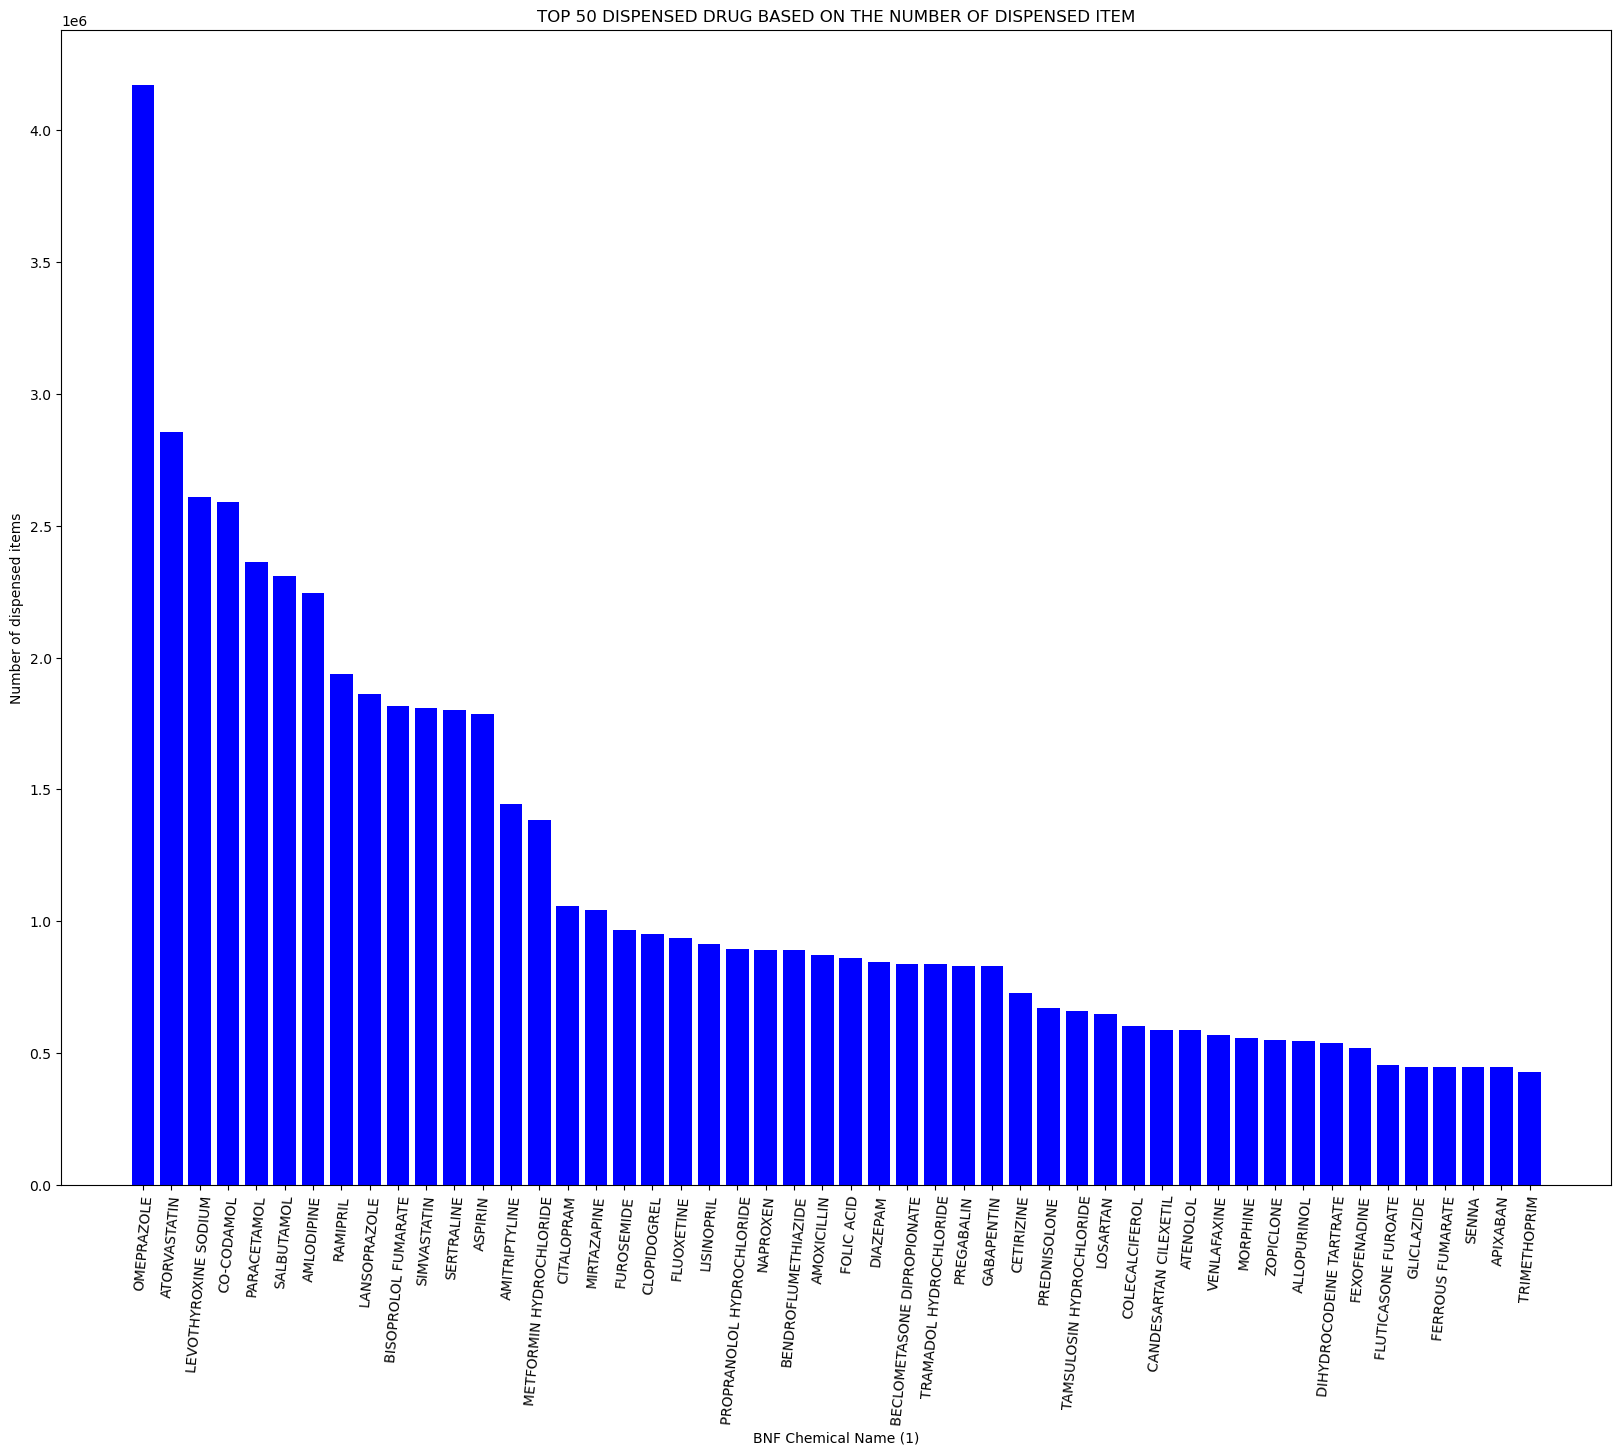

In [26]:
top_50 = common_dispensed_drug.head(50)
plt.figure(figsize = (20, 15))
plt.bar(top_50["BNF_chemical_name(1)"], top_50["Number of dispensed items"], color = "blue")
# plt.plot(top_20['BNF_chemical_name(1)'], top_20['consumed_drug_1(kg)'], marker='o')
# plt.hist(top_20['consumed_drug_1(kg)'], bins=10, edgecolor='black')
plt.title("TOP 50 DISPENSED DRUG BASED ON THE NUMBER OF DISPENSED ITEM")
plt.ylabel("Number of dispensed items")
plt.xlabel("BNF Chemical Name (1)")
plt.xticks(rotation=85)
plt.show();

Next we check for same in the new column for the splitted drugs that came in drug mixtures

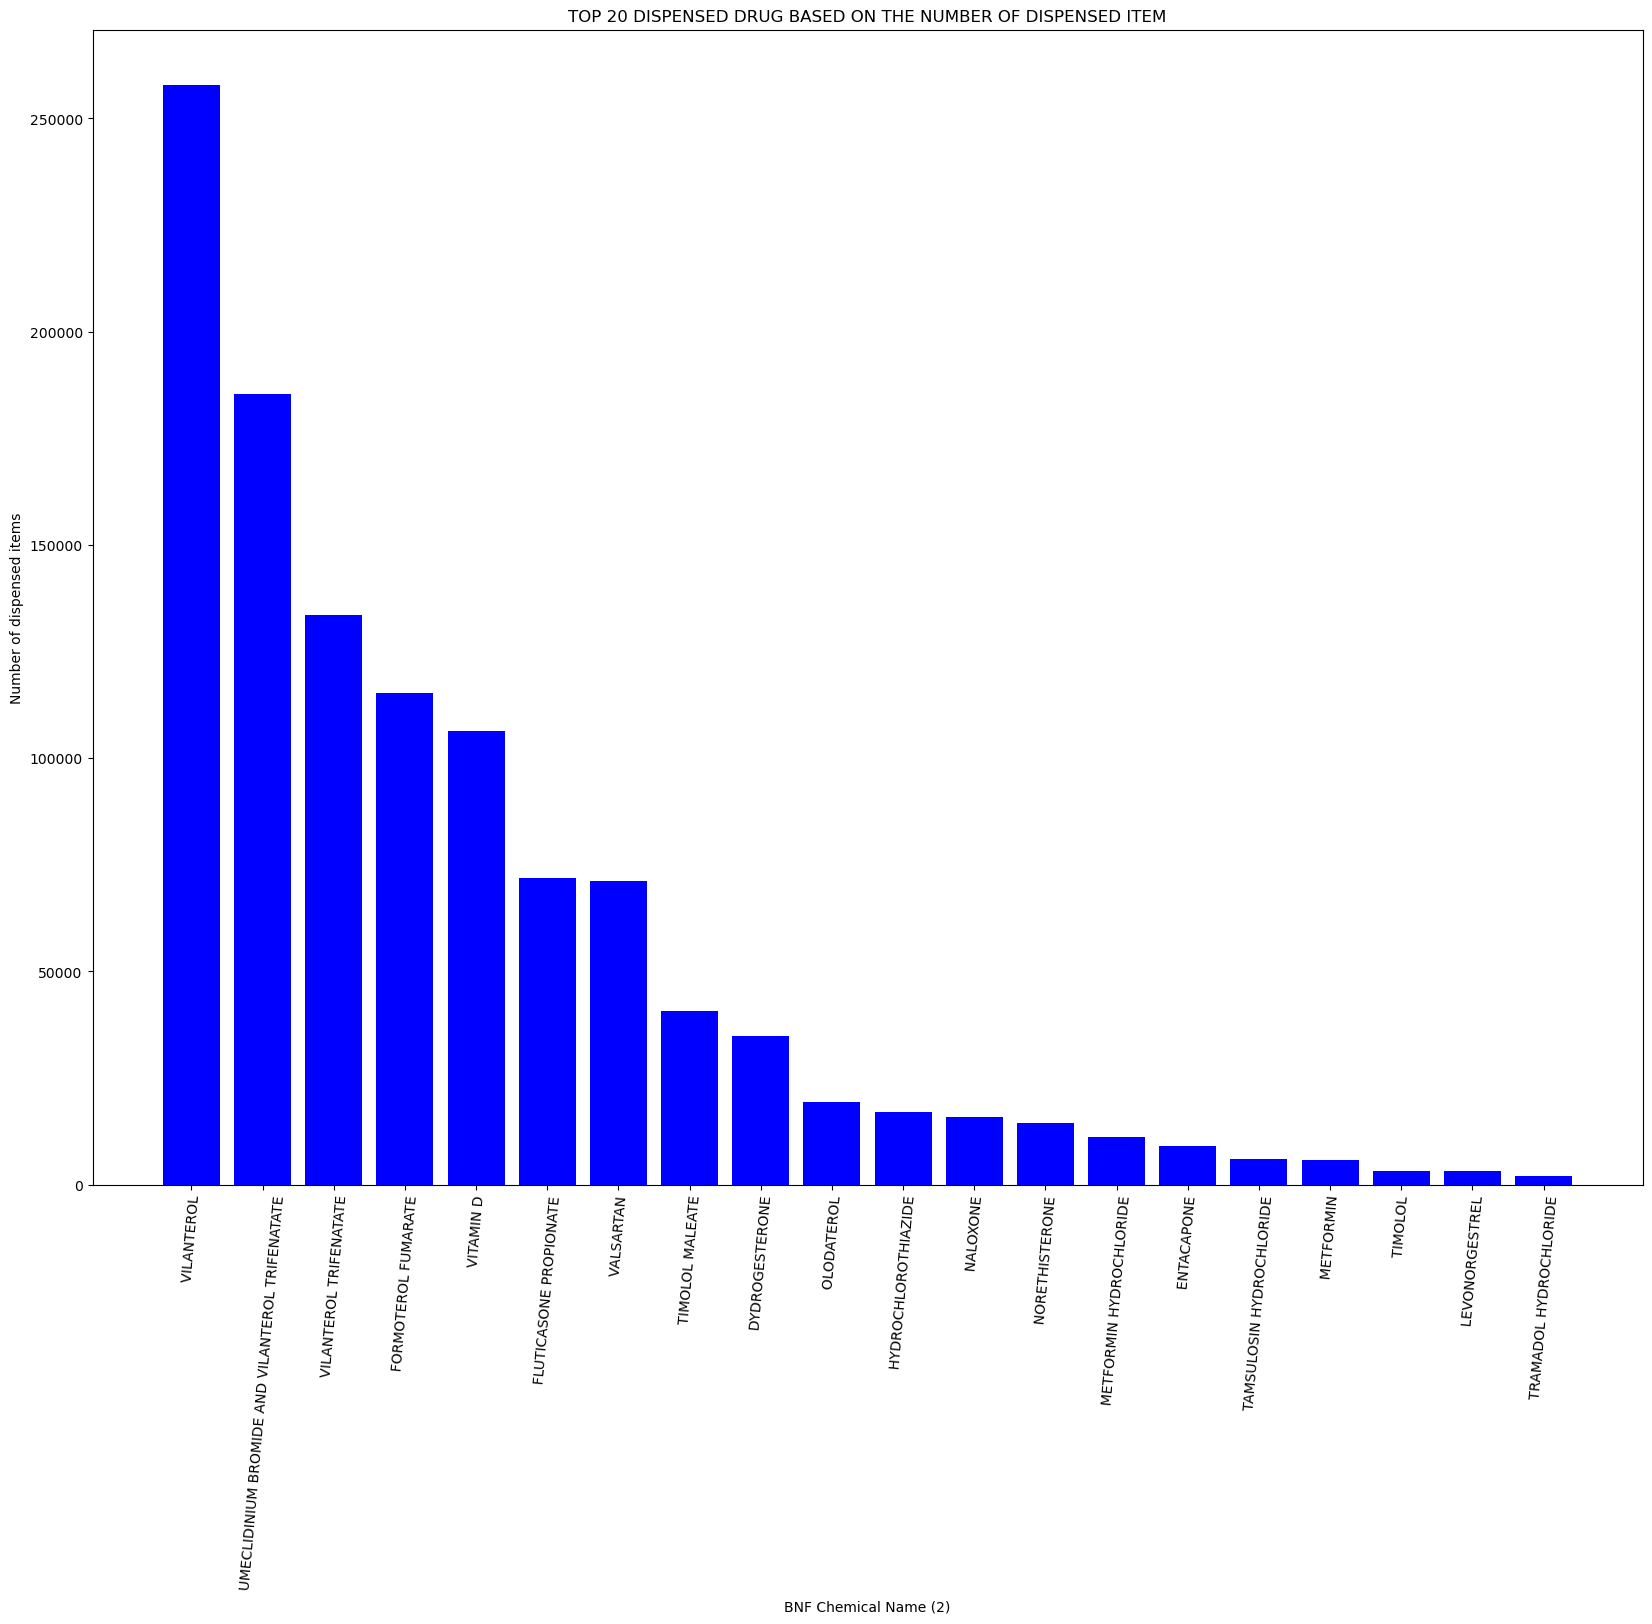

In [27]:
common_dispensed_drug = df.groupby("BNF_chemical_name(2)")["Number of dispensed items"].sum().reset_index()
common_dispensed_drug = common_dispensed_drug.sort_values("Number of dispensed items", ascending = False)
top_20 = common_dispensed_drug.head(20)
plt.figure(figsize = (20, 15))
plt.bar(top_20["BNF_chemical_name(2)"], top_20["Number of dispensed items"], color = "blue")
plt.title("TOP 20 DISPENSED DRUG BASED ON THE NUMBER OF DISPENSED ITEM")
plt.ylabel("Number of dispensed items")
plt.xlabel("BNF Chemical Name (2)")
plt.xticks(rotation=85)
plt.show();

Are there any associations between disease groups and specific drugs or medication types?

This section we grouped the data by disease group and lists the unique drugs associated with each disease group. To identify which drugs or medication types are commonly prescribed for specific disease groups.

In [28]:
# Group the DataFrame by BNF sub-section and gather the unique chemical names within each group
grouped_df = df.groupby('BNF sub-section')['BNF_chemical_name(1)'].unique()

# Print the relationship between BNF sub-section groups and specific chemical names or medication types
for sub_section, chem_names in grouped_df.items():
    print(f'BNF sub-section: {sub_section}')
    print(f'Chemical names or medication types: {chem_names}')
    print()

BNF sub-section: ADRENOCEPTOR AGONISTS
Chemical names or medication types: ['BAMBUTEROL HYDROCHLORIDE' 'EPHEDRINE HYDROCHLORIDE'
 'FORMOTEROL FUMARATE' 'INDACATEROL' 'OLODATEROL' 'SALBUTAMOL'
 'SALMETEROL' 'TERBUTALINE SULFATE']

BNF sub-section: ALCOHOL DEPENDENCE
Chemical names or medication types: ['ACAMPROSATE CALCIUM' 'DISULFIRAM' 'NALMEFENE']

BNF sub-section: ALKYLATING DRUGS
Chemical names or medication types: ['BUSULFAN' 'CYCLOPHOSPHAMIDE']

BNF sub-section: ALLERGEN IMMUNOTHERAPY
Chemical names or medication types: ['BENRALIZUMAB' 'MEPOLIZUMAB' 'OMALIZUMAB']

BNF sub-section: ALLERGIC EMERGENCIES
Chemical names or medication types: ['EPINEPHRINE']

BNF sub-section: ALPHA-ADRENOCEPTOR BLOCKING DRUGS
Chemical names or medication types: ['DOXAZOSIN' 'PHENOXYBENZAMINE HYDROCHLORIDE' 'PRAZOSIN HYDROCHLORIDE'
 'TERAZOSIN']

BNF sub-section: AMINOGLYCOSIDES
Chemical names or medication types: ['AMIKACIN' 'GENTAMICIN' 'NEOMYCIN SULFATE' 'TOBRAMYCIN']

BNF sub-section: AMINOSALICYLATE

To identify the disease group that had the highest unique drug count associated with the disease groups we visualize using the bar plot below.

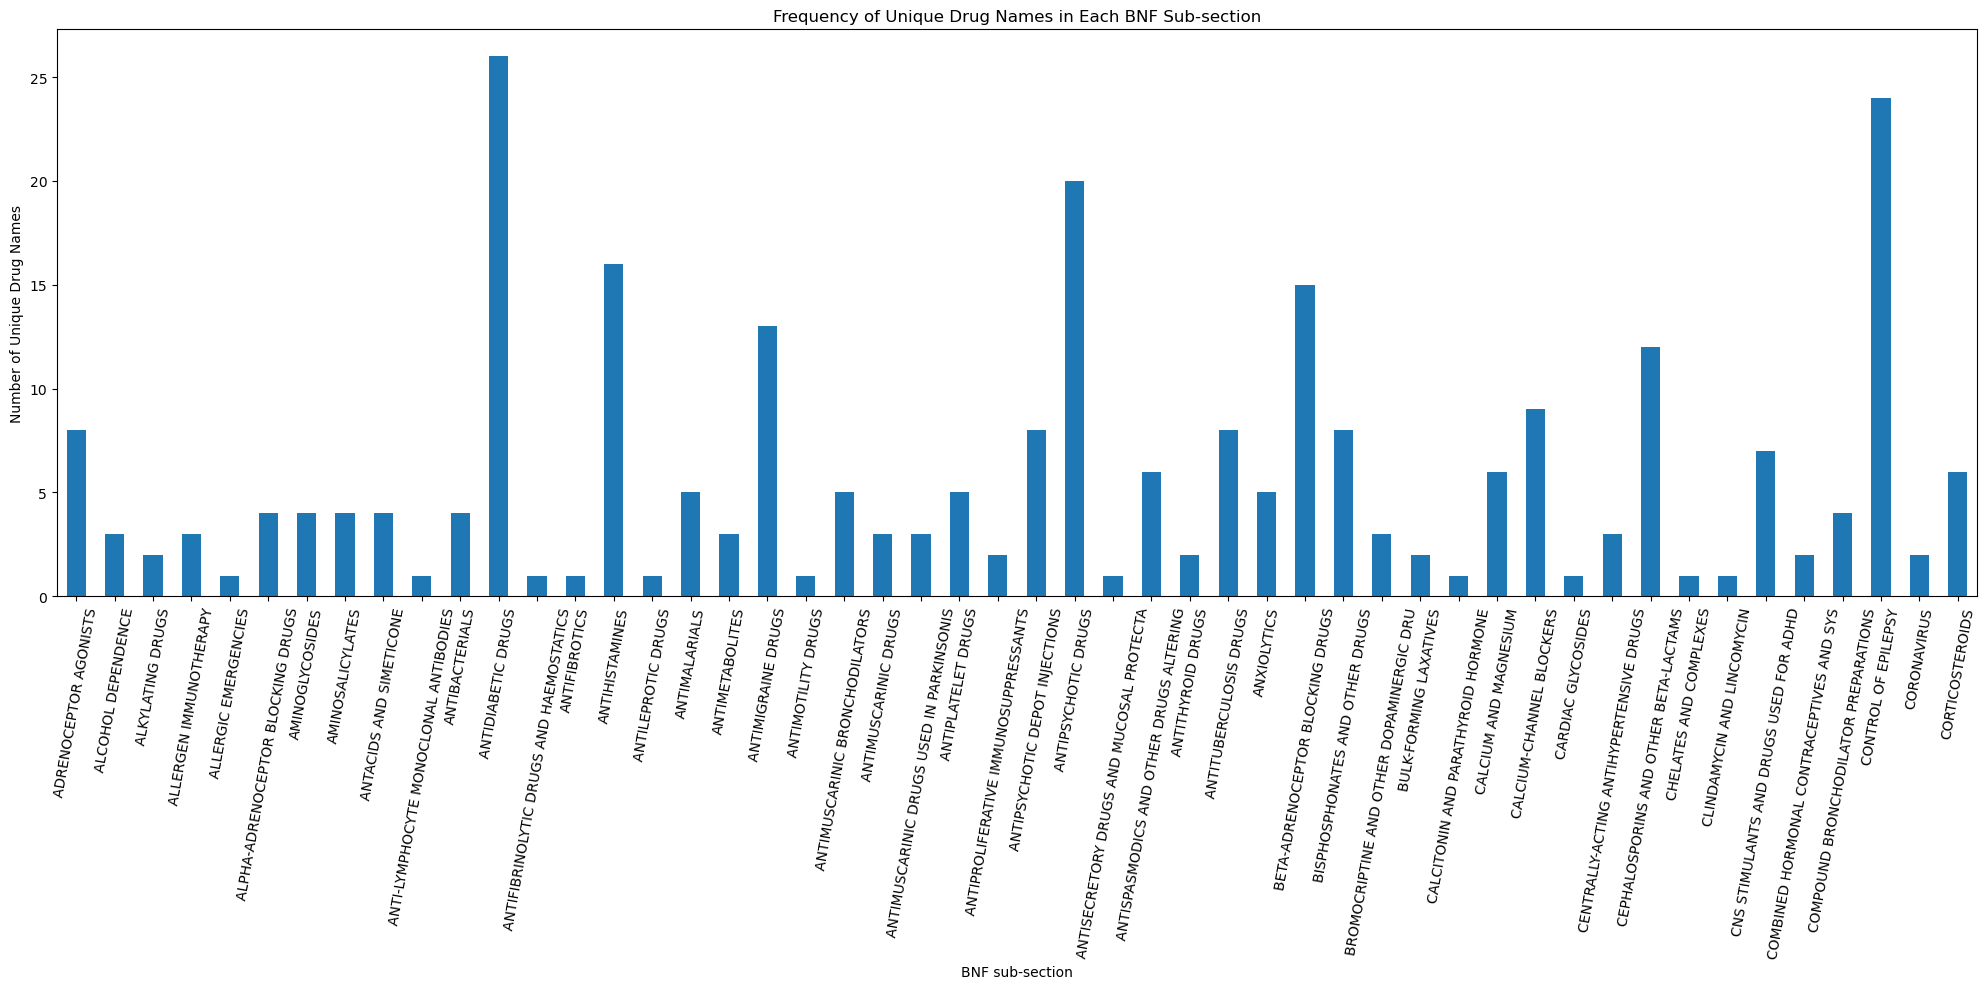

In [29]:
# Count the unique drug names for each BNF sub-section
unique_drug_counts = df.groupby('BNF sub-section')['BNF_chemical_name(1)'].nunique()
unique_drug_counts = unique_drug_counts.head(50)
# Plot the bar chart
plt.figure(figsize=(20, 10))
unique_drug_counts.plot(kind='bar')
plt.xlabel('BNF sub-section')
plt.ylabel('Number of Unique Drug Names')
plt.title('Frequency of Unique Drug Names in Each BNF Sub-section')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

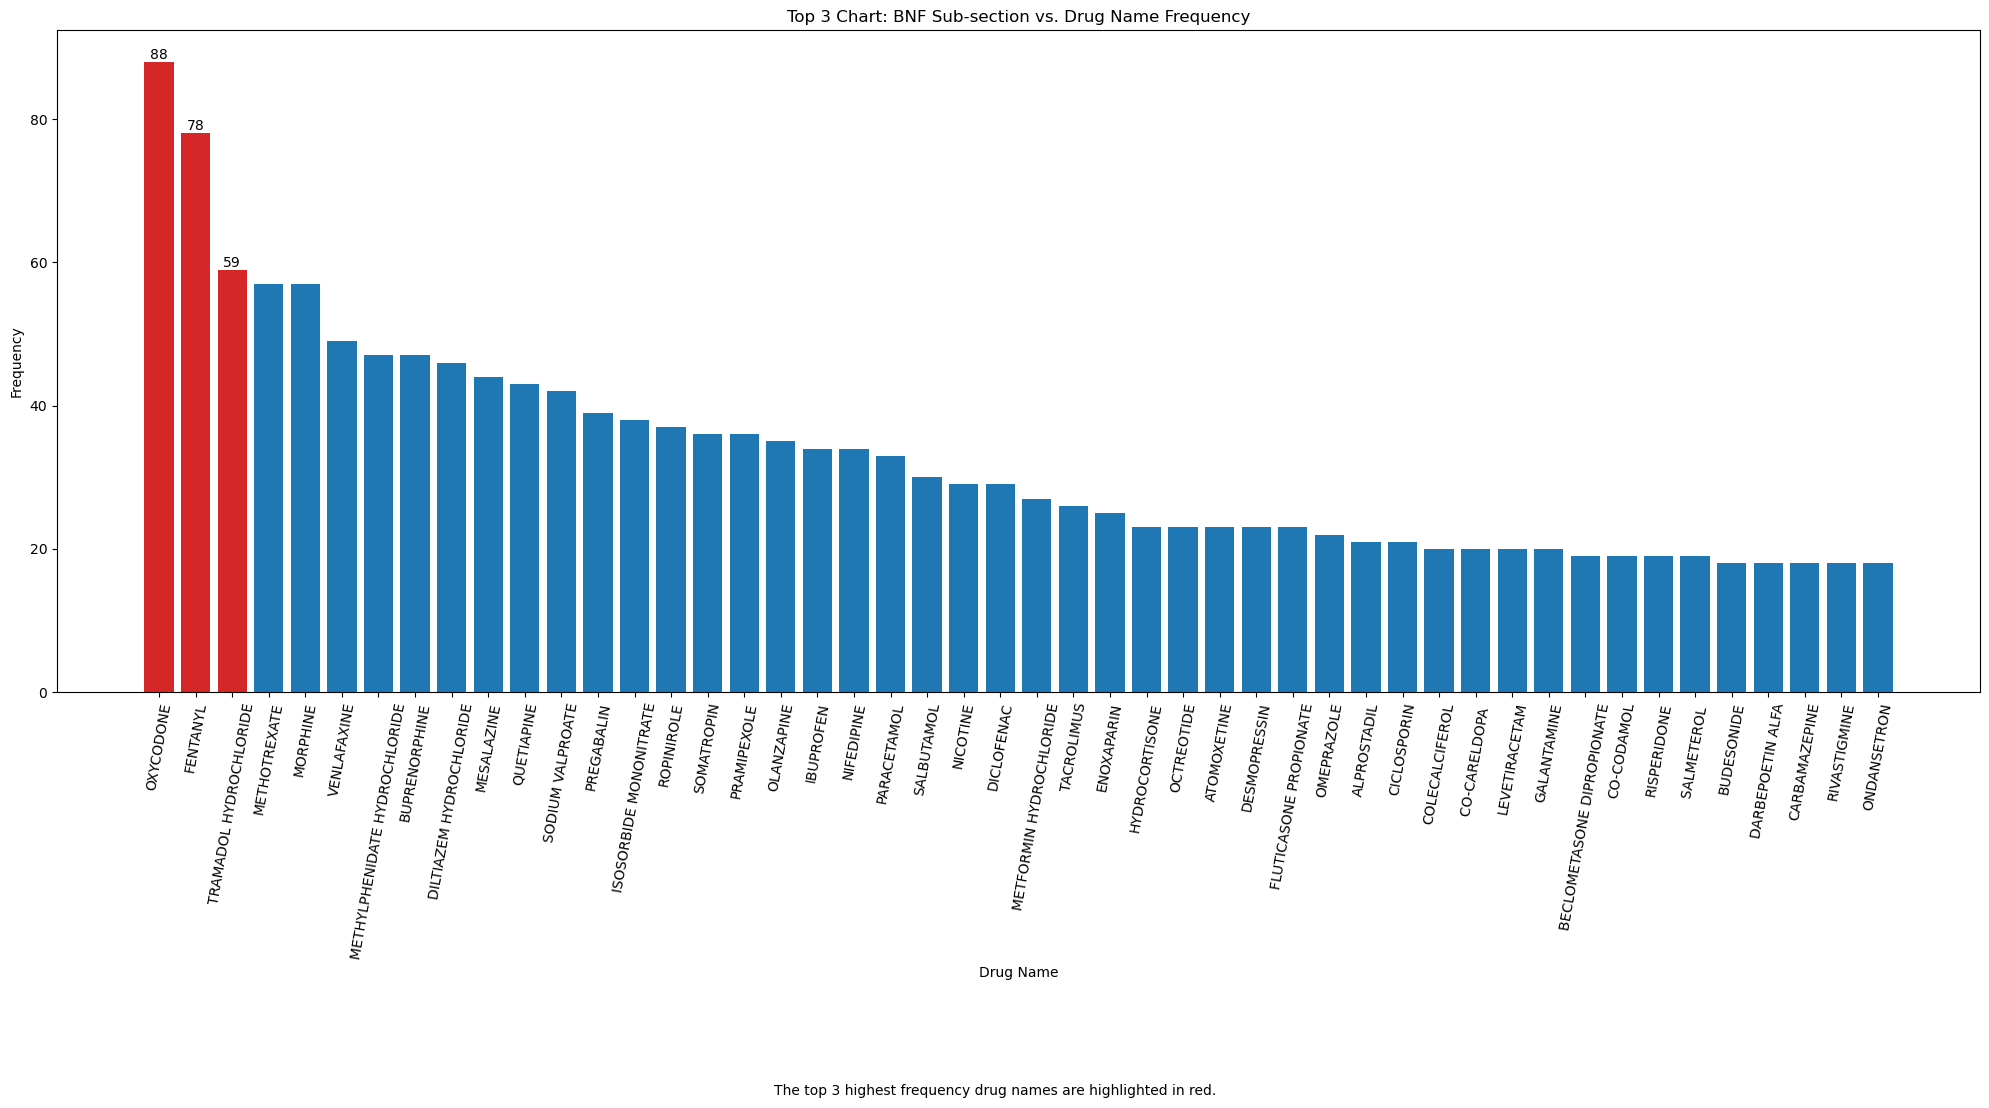

In [30]:
drug_name_counts = df.groupby(['BNF sub-section', 'BNF_chemical_name(1)']).size().reset_index(name='Frequency')

# Sort the frequencies in descending order
drug_name_counts = drug_name_counts.sort_values(by='Frequency', ascending=False)
drug_name_counts = drug_name_counts.head(50)
# Get the top 3 highest frequencies
top_3_drug_name_counts = drug_name_counts.head(3)

# Create a color list for the top 3 highest frequencies
colors = ['tab:red' if name in top_3_drug_name_counts['BNF_chemical_name(1)'].values else 'tab:blue' for name in drug_name_counts['BNF_chemical_name(1)']]

# Plot the top 3 chart
plt.figure(figsize=(20, 10))
plt.bar(drug_name_counts['BNF_chemical_name(1)'], drug_name_counts['Frequency'], color=colors)
plt.xlabel('Drug Name')
plt.ylabel('Frequency')
plt.title('Top 3 Chart: BNF Sub-section vs. Drug Name Frequency')
plt.xticks(rotation=80)

# Add annotations for the top 3 highest frequencies
for i, freq in enumerate(top_3_drug_name_counts['Frequency']):
    plt.annotate(freq, (top_3_drug_name_counts.iloc[i]['BNF_chemical_name(1)'], freq), ha='center', va='bottom')

# Add a comment to the result
plt.figtext(0.5, -0.1, 'The top 3 highest frequency drug names are highlighted in red.', wrap=True, horizontalalignment='center', fontsize=10)

plt.tight_layout()
plt.show()

The resulting bar chart provides a visual representation of how the consumed drug quantity varies across different disease
groups, allowing you to observe the relative differences in drug consumption.

How does the consumed drug quantity (in kilograms) vary across different disease groups?

We visualized the distribution of consumed drug weights for each disease group.

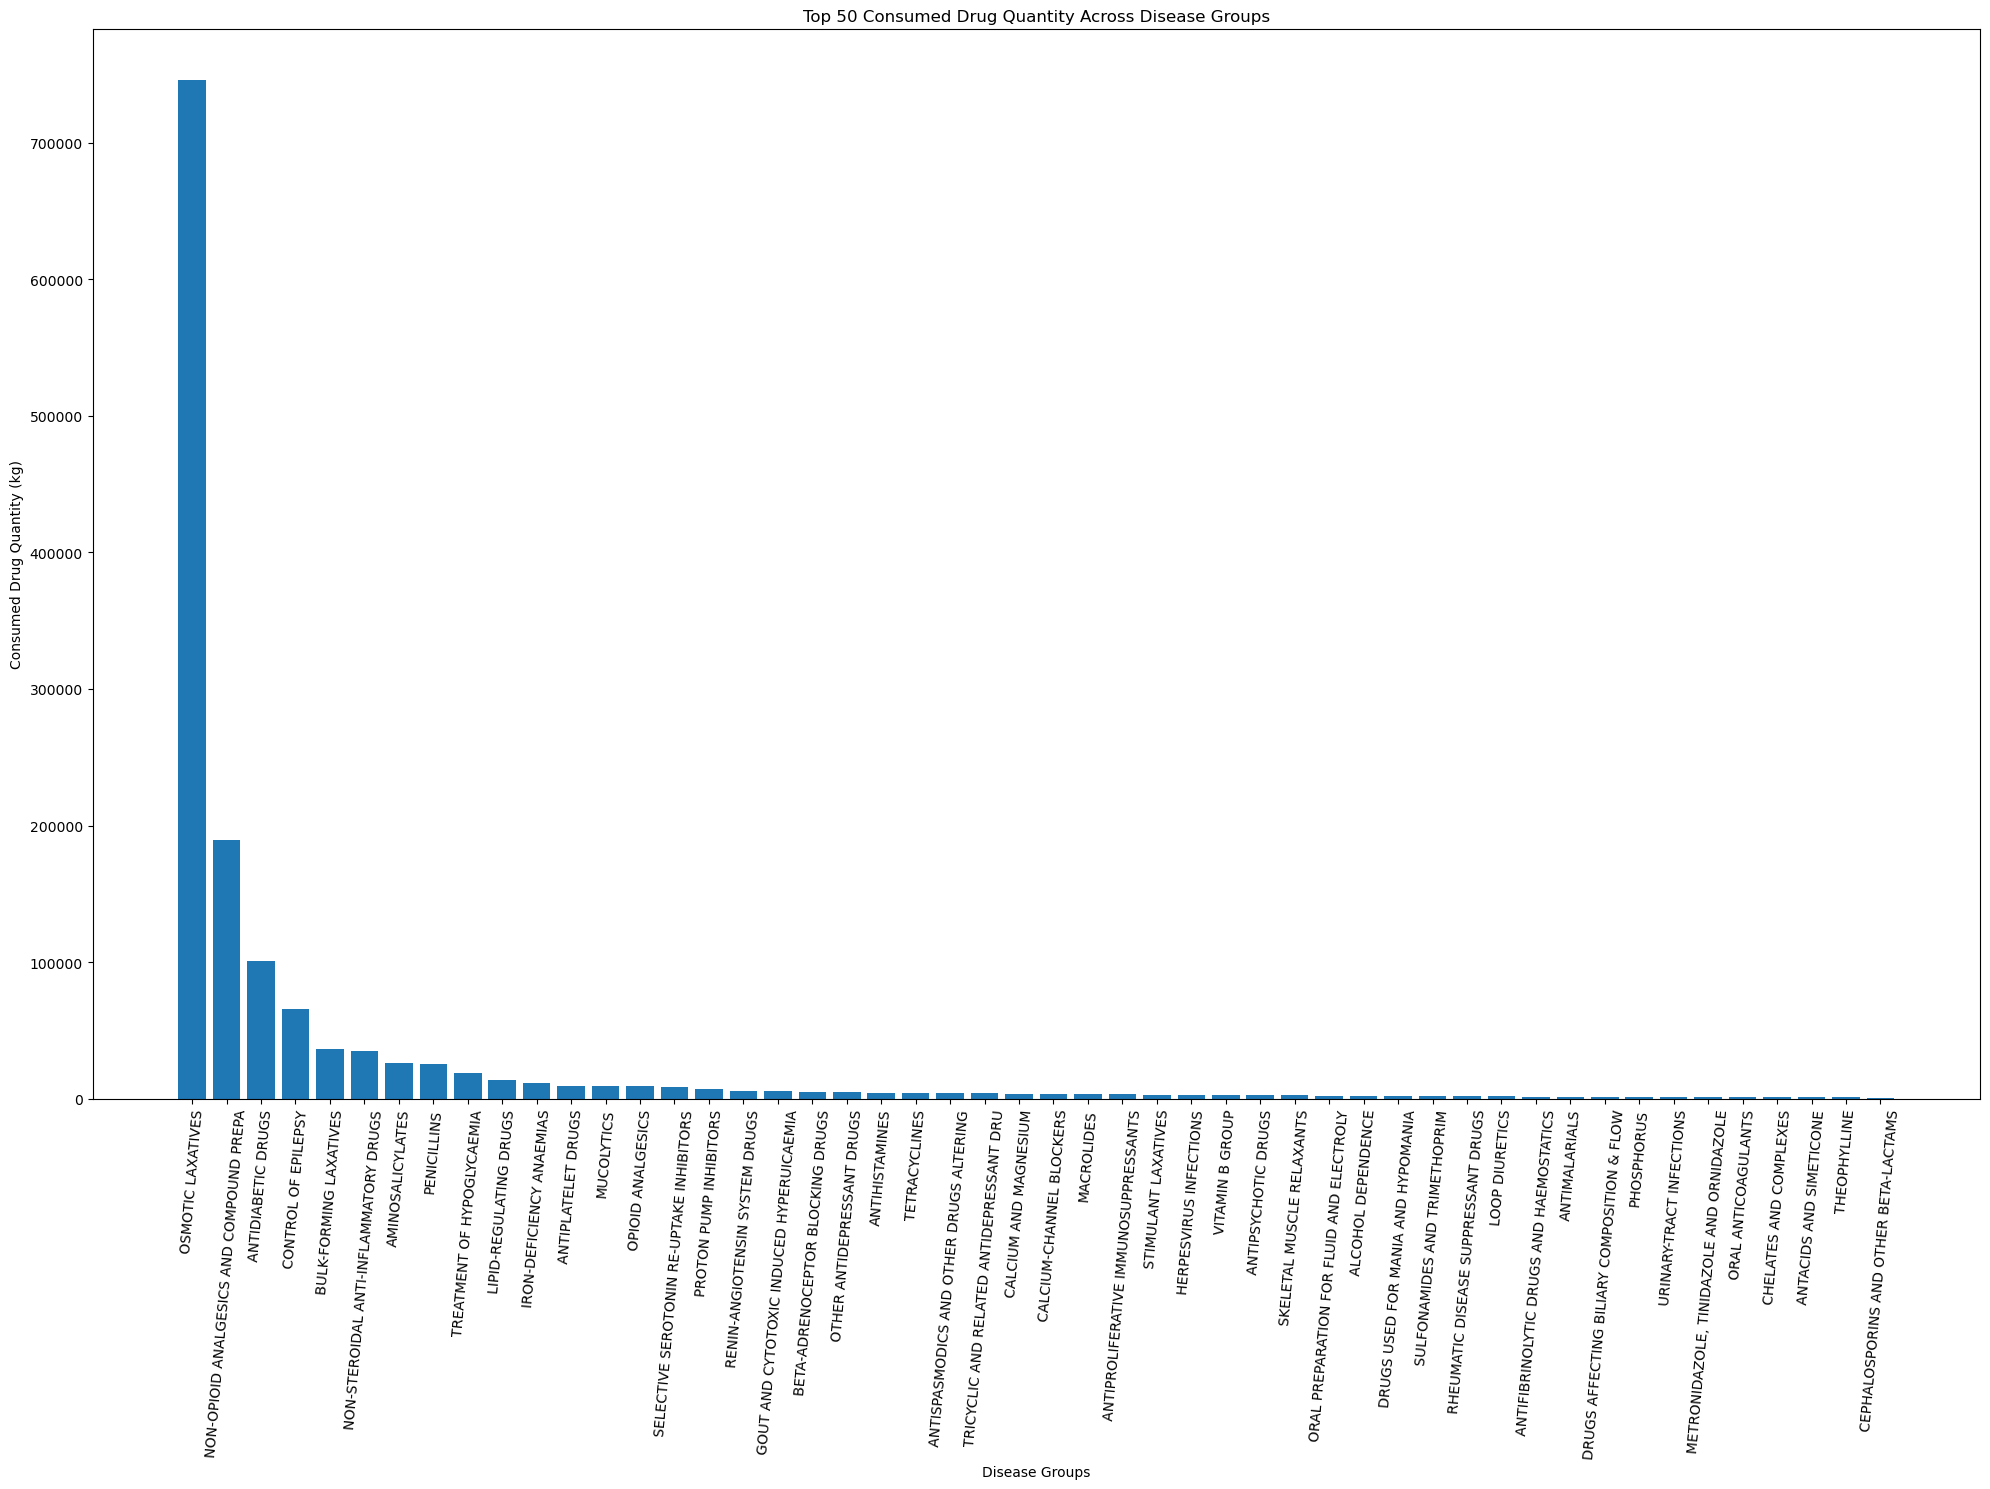

In [31]:
grouped_df = df.groupby('BNF sub-section')['consumed_drug_1(kg)'].sum().reset_index()

# Sort the data by the consumed drug quantity in descending order
sorted_df = grouped_df.sort_values('consumed_drug_1(kg)', ascending=False)
sorted_df = sorted_df.head(50)
# Plot a bar chart to visualize the consumed drug quantity across disease groups
plt.figure(figsize = (20, 15))
plt.bar(sorted_df['BNF sub-section'], sorted_df['consumed_drug_1(kg)'])
plt.xlabel('Disease Groups')
plt.ylabel('Consumed Drug Quantity (kg)')
plt.title('Top 50 Consumed Drug Quantity Across Disease Groups')
plt.xticks(rotation=85)
plt.tight_layout()
plt.show()

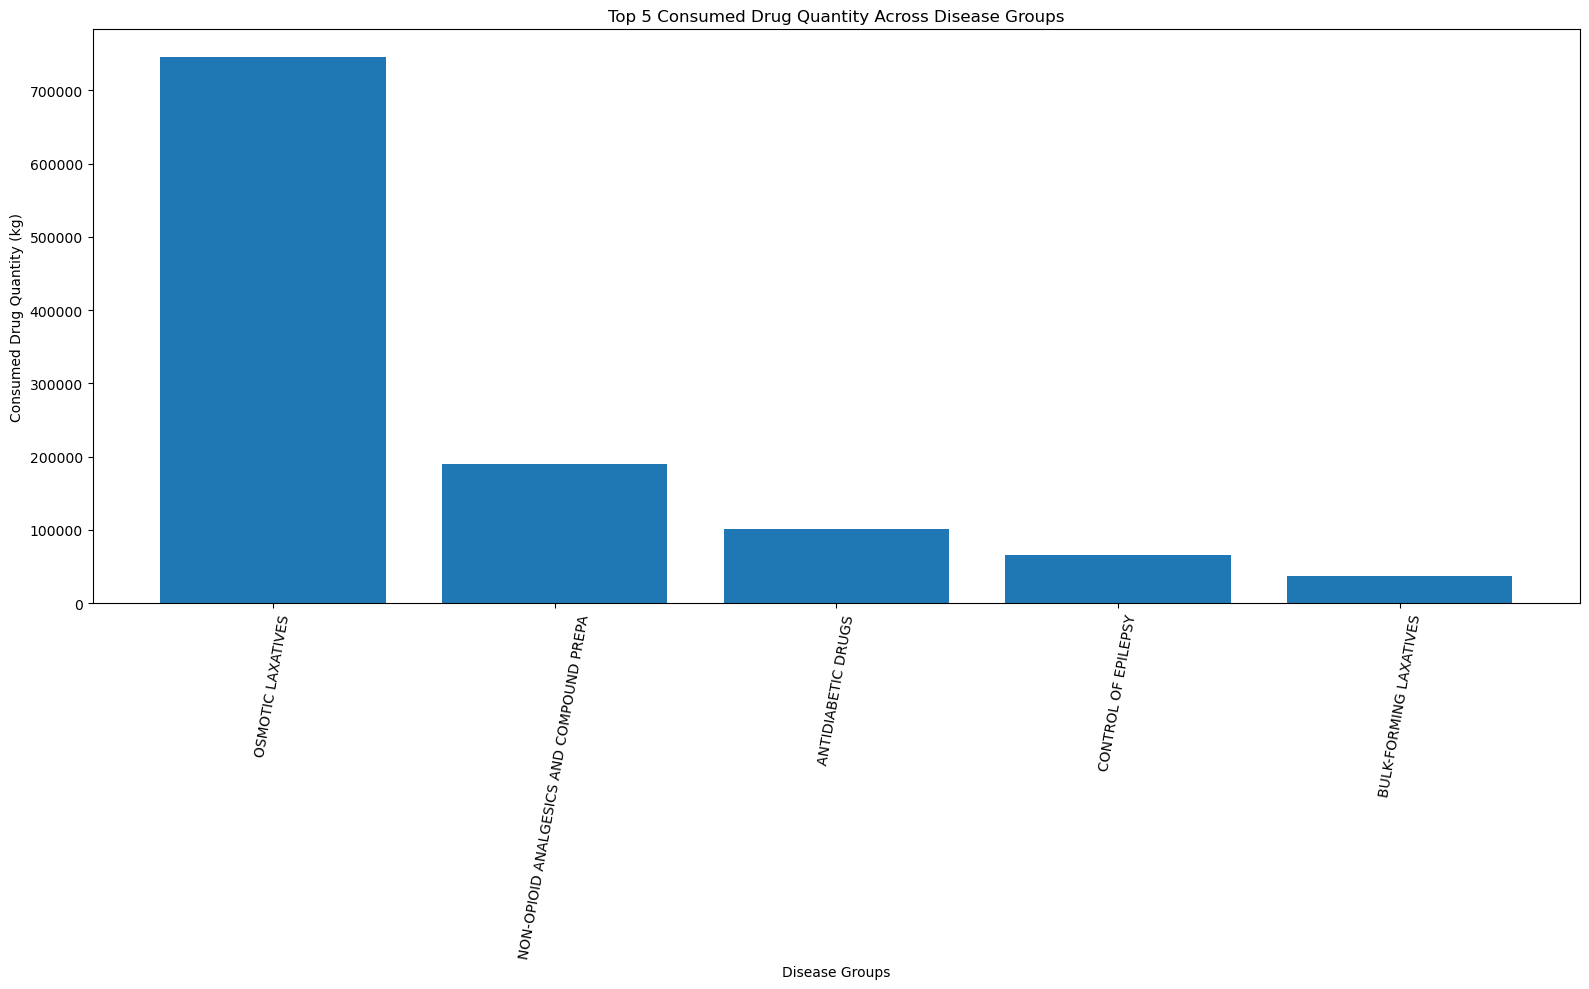

In [32]:
grouped_df = df.groupby('BNF sub-section')['consumed_drug_1(kg)'].sum().reset_index()

# Sort the data by the consumed drug quantity in descending order
sorted_df_5 = grouped_df.sort_values('consumed_drug_1(kg)', ascending=False)
sorted_df_5 = sorted_df.head(5)
# Plot a bar chart to visualize the consumed drug quantity across disease groups
plt.figure(figsize = (16, 10))
plt.bar(sorted_df_5['BNF sub-section'], sorted_df_5['consumed_drug_1(kg)'])
plt.xlabel('Disease Groups')
plt.ylabel('Consumed Drug Quantity (kg)')
plt.title('Top 5 Consumed Drug Quantity Across Disease Groups')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()

Is there a correlation between the gross ingredient cost and the dispensed quantity of drugs?

In [33]:
correlation = df["Gross ingredient cost (£)"].corr(df["Dispensed quantity"])

print("The correlation between Gross ingredient cost (£) and Dispensed quantity is:", correlation)

# Provide a short note on the correlation
if correlation > 0:
    print("There is a positive correlation between the Gross ingredient cost (£) and Dispensed quantity.")
    print("This means that as the Gross ingredient cost increases, the Dispensed quantity also tends to increase.")
elif correlation < 0:
    print("There is a negative correlation between the Gross ingredient cost (£) and Dispensed quantity.")
    print("This means that as the Gross ingredient cost increases, the Dispensed quantity tends to decrease.")
else:
    print("There is no linear correlation between the Gross ingredient cost (£) and Dispensed quantity.")

The correlation between Gross ingredient cost (£) and Dispensed quantity is: 0.2990826709822178
There is a positive correlation between the Gross ingredient cost (£) and Dispensed quantity.
This means that as the Gross ingredient cost increases, the Dispensed quantity also tends to increase.


Are there significant differences in the consumed drug weights for specific drug classes or therapeutic categories?

In [34]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from scipy.stats import f_oneway

groups = df['BNF_chemical_name(1)'].unique()
grouped_data = [df[df['BNF_chemical_name(1)'] == group]['consumed_drug_1(kg)'] for group in groups]
statistic, p_value = f_oneway(*grouped_data)

# Print the results
print("ANOVA Results:")
print("p-value:", p_value)

if p_value < 0.00:
    print("There are significant differences in the consumed drug weights among the groups.")
else:
    print("There are no significant differences in the consumed drug weights among the groups.")

ANOVA Results:
p-value: nan
There are no significant differences in the consumed drug weights among the groups.


# Drug Utilization Analysis

Analyzing the distribution of dispensed quantities and the number of dispensed items for different drugs. Identifying the most frequently prescribed drugs and any variations.

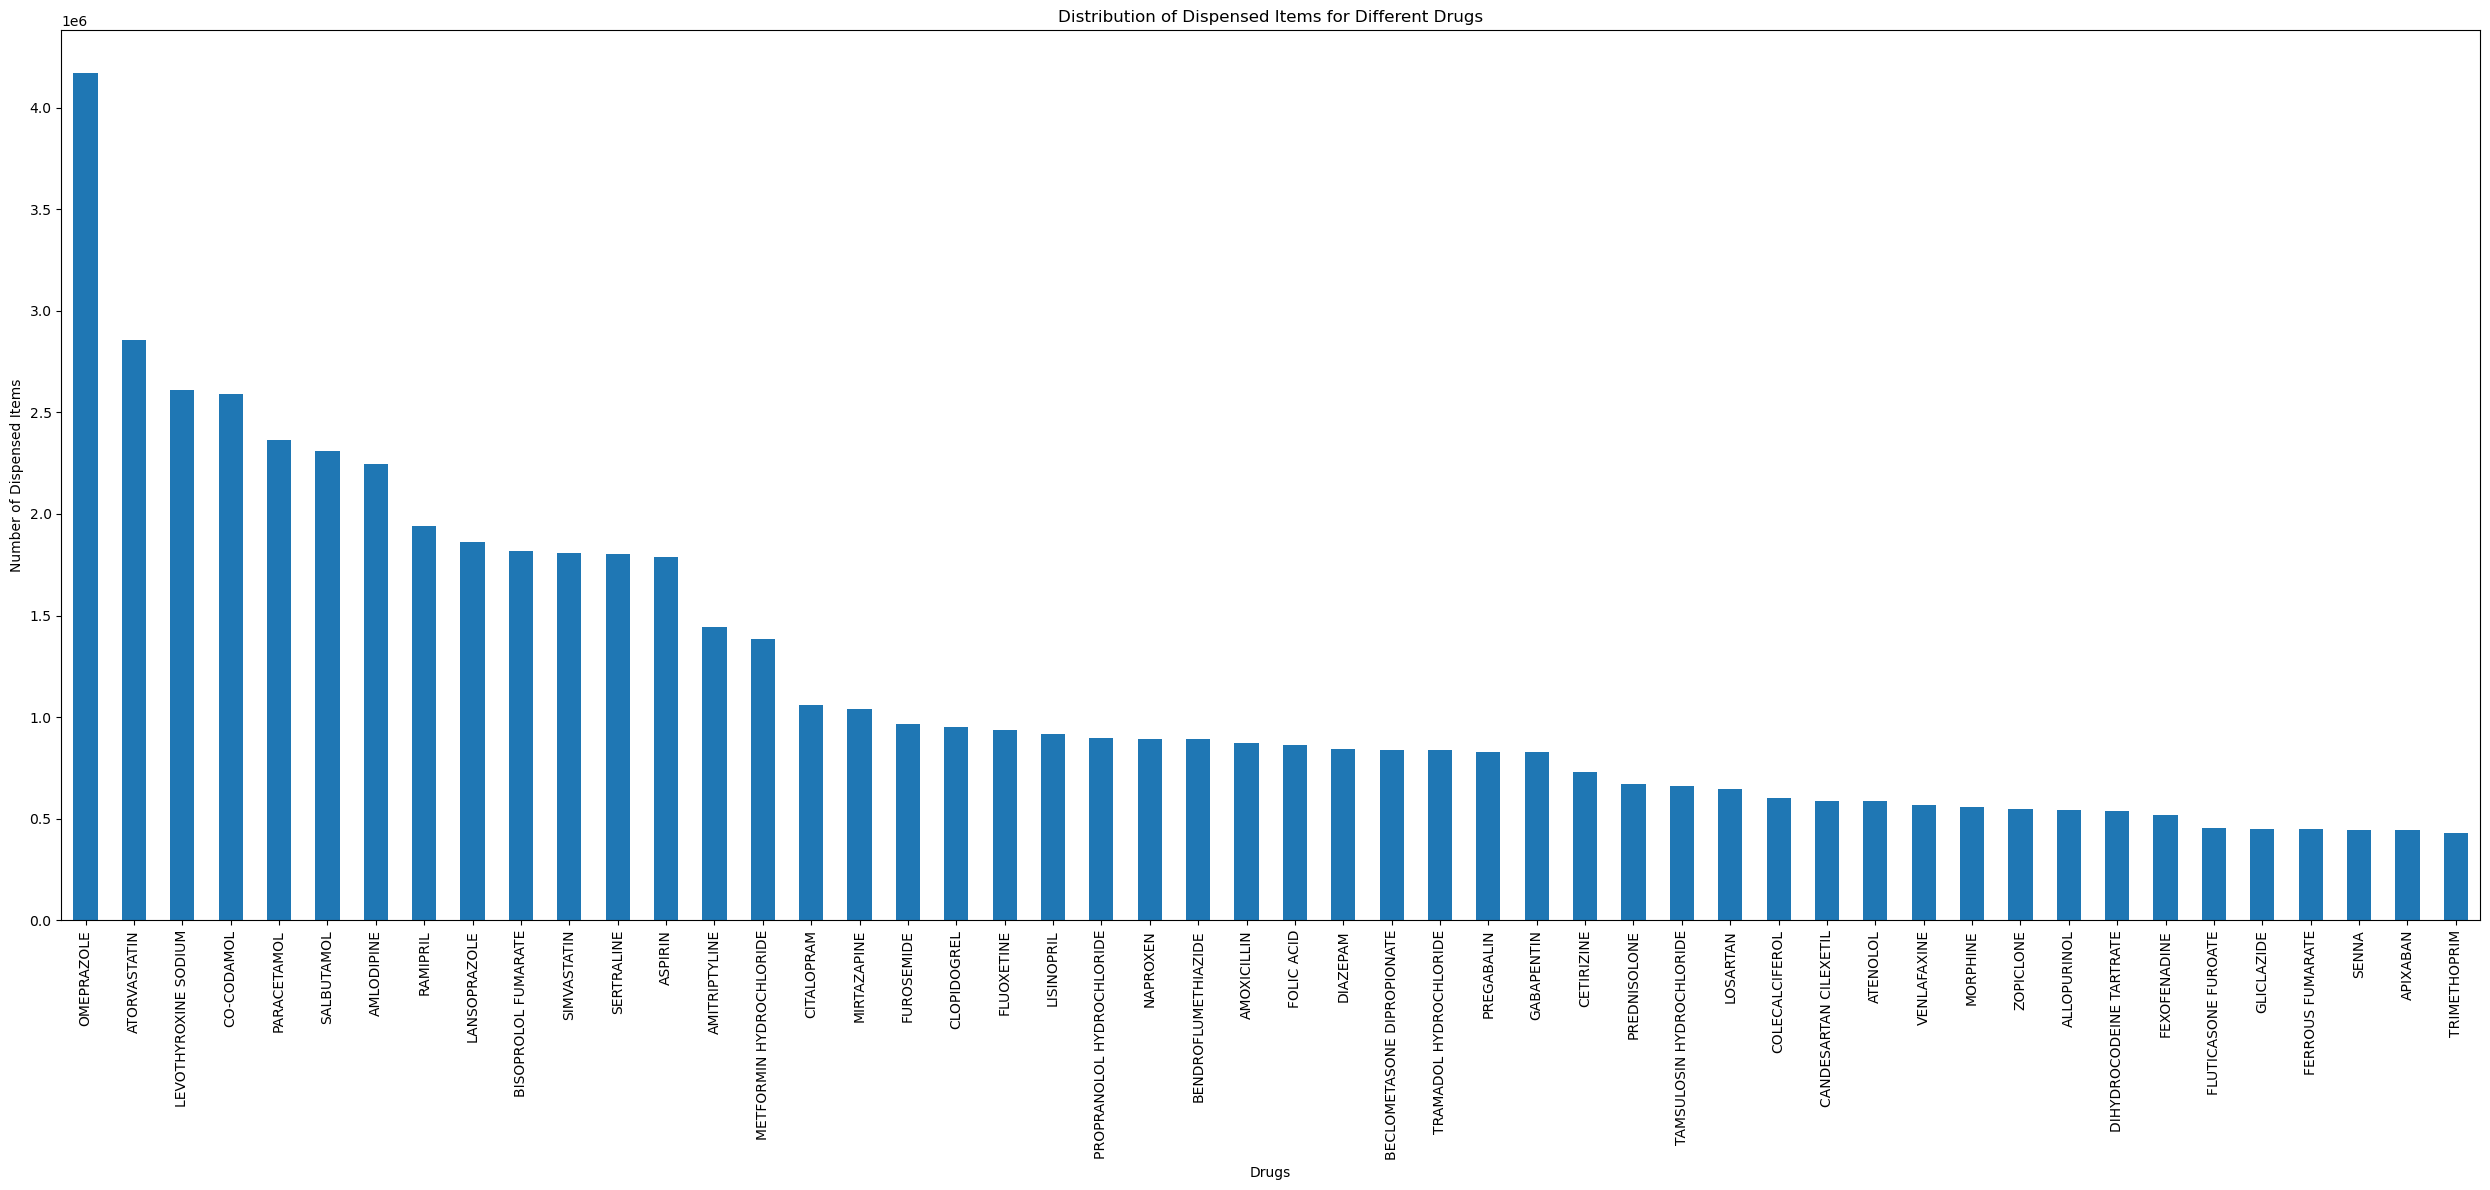

The most frequently prescribed drugs:
                      Dispensed quantity  Number of dispensed items
BNF_chemical_name(1)                                               
OMEPRAZOLE                  2.133169e+08                    4172092
ATORVASTATIN                1.312170e+08                    2855330
LEVOTHYROXINE SODIUM        1.303484e+08                    2610046
CO-CODAMOL                  3.043742e+08                    2591231
PARACETAMOL                 4.358794e+08                    2362586


In [35]:
# Calculate the total dispensed quantity and number of dispensed items for each drug
grouped_df = df.groupby('BNF_chemical_name(1)').agg({'Dispensed quantity': 'sum', 'Number of dispensed items': 'sum'})

# Sort the drugs based on the number of dispensed items in descending order
sorted_df = grouped_df.sort_values('Number of dispensed items', ascending=False)
sorted_df = sorted_df.head(50)
# Plot the number of dispensed items for each drug
plt.figure(figsize=(25, 12))
sorted_df['Number of dispensed items'].plot(kind='bar')
plt.xlabel('Drugs')
plt.ylabel('Number of Dispensed Items')
plt.title('Distribution of Dispensed Items for Different Drugs')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Print the most frequently prescribed drugs
print("The most frequently prescribed drugs:")
print(sorted_df.head())

# Analyze variations in dispensed quantities and number of dispensed items
variation = df.groupby('BNF sub-section')[['Dispensed quantity', 'Number of dispensed items']].agg(['mean', 'min', 'max', 'std'])

# # Print the variation in dispensed quantities and number of dispensed items
# print("\nVariation in Dispensed Quantities and Number of Dispensed Items:")
# print(variation)

In [36]:
 # Print the variation in dispensed quantities and number of dispensed items
sorted_df.describe()

,Dispensed quantity,Number of dispensed items
count,5.000000e+01,5.000000e+01
mean,7.073249e+07,1.157490e+06
std,7.593050e+07,7.991143e+05
min,6.162170e+05,4.285930e+05
25%,3.190029e+07,5.873820e+05
50%,4.562771e+07,8.664860e+05
75%,8.365515e+07,1.701455e+06
max,4.358794e+08,4.172092e+06


 Explore the relationship between the dispensed quantity and the number of dispensed items. Are there any patterns or trends

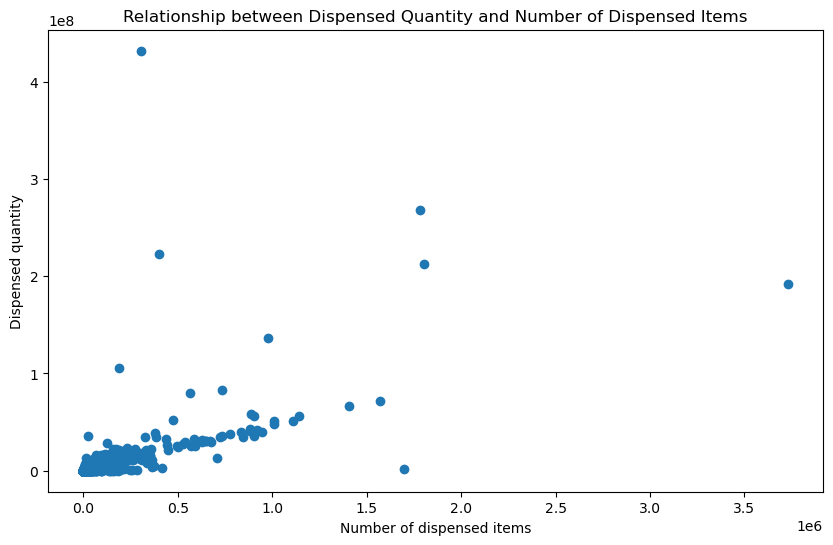

In [37]:
summary_stats = df.groupby('BNF sub-section')[['Dispensed quantity', 'Number of dispensed items']].agg(['mean', 'median', 'std'])

# Plot the relationship between dispensed quantity and number of dispensed items
plt.figure(figsize=(10, 6))
plt.scatter(df['Number of dispensed items'], df['Dispensed quantity'])
plt.xlabel('Number of dispensed items')
plt.ylabel('Dispensed quantity')
plt.title('Relationship between Dispensed Quantity and Number of Dispensed Items')
plt.show()

In [38]:
correlation = df["Number of dispensed items"].corr(df["Dispensed quantity"])

print("The correlation between Number of dispensed items and Dispensed quantity is:", correlation)

# Provide a short note on the correlation
if correlation > 0:
    print("There is a high positive correlation between the Number of dispensed items and Dispensed quantity.")
    print("This means that as the Number of dispensed items increases, the Dispensed quantity also tends to increase.")
elif correlation < 0:
    print("There is a negative correlation between the Number of dispensed items and Dispensed quantity.")
    print("This means that as the Number of dispensed items increases, the Dispensed quantity tends to decrease.")
else:
    print("There is no linear correlation between the Number of dispensed items and Dispensed quantity.")

The correlation between Number of dispensed items and Dispensed quantity is: 0.6552277506618962
There is a high positive correlation between the Number of dispensed items and Dispensed quantity.
This means that as the Number of dispensed items increases, the Dispensed quantity also tends to increase.


# Disease Group Analysis

Investigating the distribution of drugs across different disease groups. Identify the most prevalent disease groups and the corresponding drugs.

In [39]:
drug_counts = df.groupby(['BNF sub-section', 'BNF_chemical_name(1)'])['Number of dispensed items'].count()

# Find the most prevalent disease groups and their corresponding drugs
most_prevalent_groups = drug_counts.groupby('BNF sub-section').idxmax()

# Print the most prevalent disease groups and their corresponding drugs
for group, drug in most_prevalent_groups:
    print("Most prevalent disease group:", group)
    print("Corresponding drug:", drug)
    print()

Most prevalent disease group: ADRENOCEPTOR AGONISTS
Corresponding drug: SALBUTAMOL

Most prevalent disease group: ALCOHOL DEPENDENCE
Corresponding drug: ACAMPROSATE CALCIUM

Most prevalent disease group: ALKYLATING DRUGS
Corresponding drug: BUSULFAN

Most prevalent disease group: ALLERGEN IMMUNOTHERAPY
Corresponding drug: MEPOLIZUMAB

Most prevalent disease group: ALLERGIC EMERGENCIES
Corresponding drug: EPINEPHRINE

Most prevalent disease group: ALPHA-ADRENOCEPTOR BLOCKING DRUGS
Corresponding drug: DOXAZOSIN

Most prevalent disease group: AMINOGLYCOSIDES
Corresponding drug: TOBRAMYCIN

Most prevalent disease group: AMINOSALICYLATES
Corresponding drug: MESALAZINE

Most prevalent disease group: ANTACIDS AND SIMETICONE
Corresponding drug: ACTIVATED SIMETICONE

Most prevalent disease group: ANTI-LYMPHOCYTE MONOCLONAL ANTIBODIES
Corresponding drug: RITUXIMAB

Most prevalent disease group: ANTIBACTERIALS
Corresponding drug: LEVOFLOXACIN

Most prevalent disease group: ANTIDIABETIC DRUGS
Corr

In [40]:
# Group the drugs by disease group and count the frequency of each drug
drug_counts = df.groupby(['BNF sub-section', 'BNF_chemical_name(1)']).size().reset_index(name='Frequency')

# Sort the drug counts in descending order
sorted_drug_counts = drug_counts.sort_values(by='Frequency', ascending=False)

# Identify the most prevalent disease groups and their corresponding drugs
most_prevalent_groups = sorted_drug_counts.groupby('BNF sub-section').first()

# Display the most prevalent disease groups and their corresponding drugs
result = most_prevalent_groups[['BNF_chemical_name(1)', 'Frequency']]
result.head(20)


,BNF_chemical_name(1),Frequency
BNF sub-section,,
ADRENOCEPTOR AGONISTS,SALBUTAMOL,30
ALCOHOL DEPENDENCE,NALMEFENE,2
ALKYLATING DRUGS,CYCLOPHOSPHAMIDE,1
ALLERGEN IMMUNOTHERAPY,MEPOLIZUMAB,5
ALLERGIC EMERGENCIES,EPINEPHRINE,10
ALPHA-ADRENOCEPTOR BLOCKING DRUGS,DOXAZOSIN,17
AMINOGLYCOSIDES,TOBRAMYCIN,9
AMINOSALICYLATES,MESALAZINE,44
ANTACIDS AND SIMETICONE,ACTIVATED SIMETICONE,6


The most prevalent disease groups and their corresponding drugs:
Among the disease groups, HIV INFECTION is associated with the drug ABACAVIR, which has the highest frequency.
RHEUMATIC DISEASE SUPPRESSANT DRUGS are mainly associated with the drug ABATACEPT.
HORMONE ANTAGONISTS are primarily associated with the drug ABIRATERONE.
ALCOHOL DEPENDENCE is linked to the drug ACAMPROSATE CALCIUM.
ANTIDIABETIC DRUGS are associated with the drug ACARBOSE.
BETA-ADRENOCEPTOR BLOCKING DRUGS are primarily associated with the drug ACEBUTOLOL.
NON-STEROIDAL ANTI-INFLAMMATORY DRUGS are associated with the drug ACECLOFENAC and so on.

Calculate the average consumed drug weight for each disease group and analyze any variations or outliers.

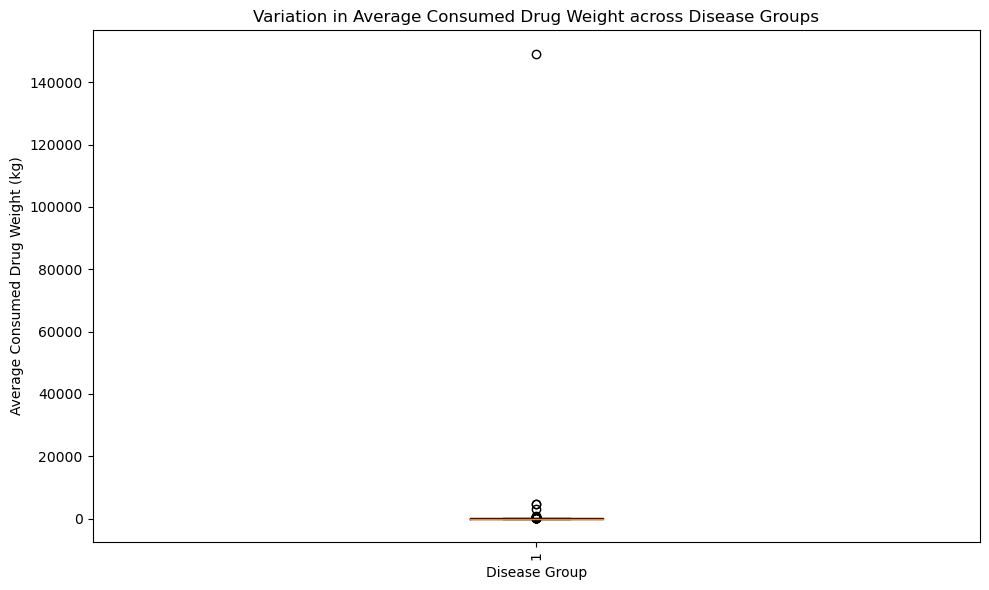

In [41]:
# Calculate the average consumed drug weight for each disease group
grouped_df = df.groupby('BNF sub-section')['consumed_drug_1(kg)'].mean()

# Plot the distribution of average consumed drug weights
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_df)
plt.xlabel('Disease Group')
plt.ylabel('Average Consumed Drug Weight (kg)')
plt.title('Variation in Average Consumed Drug Weight across Disease Groups')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [42]:

# Calculate the average consumed drug weight for each disease group
grouped_df = df.groupby('BNF sub-section')['consumed_drug_1(kg)'].mean()

# Analyze variations and outliers
mean_weight = grouped_df.mean()
std_weight = grouped_df.std()
threshold = 2  # Set the threshold for outlier detection

outliers = grouped_df[(grouped_df - mean_weight).abs() > threshold * std_weight]

# Add a comment to the result
print("Average consumed drug weight for each disease group:")
print(grouped_df)
print()

if outliers.empty:
    print("There are no outliers in the average consumed drug weight.")
else:
    print("Outliers in the average consumed drug weight:")
    print(outliers)
    print()

Average consumed drug weight for each disease group:
BNF sub-section
ADRENOCEPTOR AGONISTS        0.125717
ALCOHOL DEPENDENCE         408.776833
ALKYLATING DRUGS             0.089943
ALLERGEN IMMUNOTHERAPY       0.020153
ALLERGIC EMERGENCIES         0.003935
                              ...    
VITAMIN C                   18.993071
VITAMIN D                    0.351290
VITAMIN E                   33.900000
VITAMIN K                    0.030034
ZINC AND OTHER MINERALS      2.025274
Name: consumed_drug_1(kg), Length: 190, dtype: float64

Outliers in the average consumed drug weight:
BNF sub-section
OSMOTIC LAXATIVES    149174.637
Name: consumed_drug_1(kg), dtype: float64



The average consumed drug weight varies significantly across different disease groups.
Some disease groups have significantly higher average consumed drug weights compared to others, indicating variations in the quantity of drugs consumed for different conditions.
There is an outlier in the 'OSMOTIC LAXATIVES' group, where the average consumed drug weight is 149174.637 kg.
This outlier suggests a potential variation or special case within the 'OSMOTIC LAXATIVES' group.

# Gross Ingredient Cost Analysis

Analyzing the relationship between the consumed drug weight and the gross ingredient cost. Are there any drugs that have a higher cost despite lower consumption or vice versa?

In [43]:
#  # Group the data based on "BNF chemical name(1)" and sum the values
# grouped = df.groupby("BNF_chemical_name(1)").sum()[["Gross ingredient cost (£)", "consumed_drug_1(kg)"]]
# grouped.head()
# # # Sort the drugs based on the number of dispensed items in descending order
# # sorted_ = grouped.sort_values('consumed_drug_1(kg)', ascending=False)
# # sorted_.head()
# # Plot a scatter plot to visualize the relationship between consumed drug weight and gross ingredient cost
# plt.figure(figsize=(8, 6))
# plt.scatter(grouped['consumed_drug_1(kg)'], grouped['Gross ingredient cost (£)'])
# plt.xlabel('Consumed Drug Weight (kg)')
# plt.ylabel('Gross Ingredient Cost (£)')
# plt.title('Relationship between Consumed Drug Weight and Gross Ingredient Cost')

# # Add labels for each data point
# for i, row in df.iterrows():
#     plt.annotate(row['BNF sub-section'], (row['consumed_drug_1(kg)'], row['Gross ingredient cost (£)']))

# plt.tight_layout()
# plt.show()

In [44]:
# # Group the data based on "BNF sub-section" and "BNF_chemical_name(1)"
# grouped_data = df.groupby(["BNF sub-section", "BNF_chemical_name(1)"]).sum()

# # Select the top 50 rows based on gross ingredient cost
# top_10 = grouped_data.nlargest(10, "consumed_drug_1(kg)")

# # Create a scatter plot
# plt.figure(figsize=(12, 8))
# plt.scatter(top_10["consumed_drug_1(kg)"], top_10["Gross ingredient cost (£)"])

# # Add labels for each data point
# for index, row in top_50.iterrows():
#     plt.annotate(index[1], (row["consumed_drug_1(kg)"], row["Gross ingredient cost (£)"]),
#                  textcoords="offset points", xytext=(0,5), ha='center')

# # Set labels and title
# plt.xlabel("Consumed Drug Weight (kg)")
# plt.ylabel("Gross Ingredient Cost (£)")
# plt.title("Top 10 Scatter Plot of Consumed Drug Weight vs. Gross Ingredient Cost")

# # Display the plot
# plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_1408\618343300.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = df.groupby("BNF_chemical_name(1)").sum()[["Gross ingredient cost (£)", "consumed_drug_1(kg)"]]


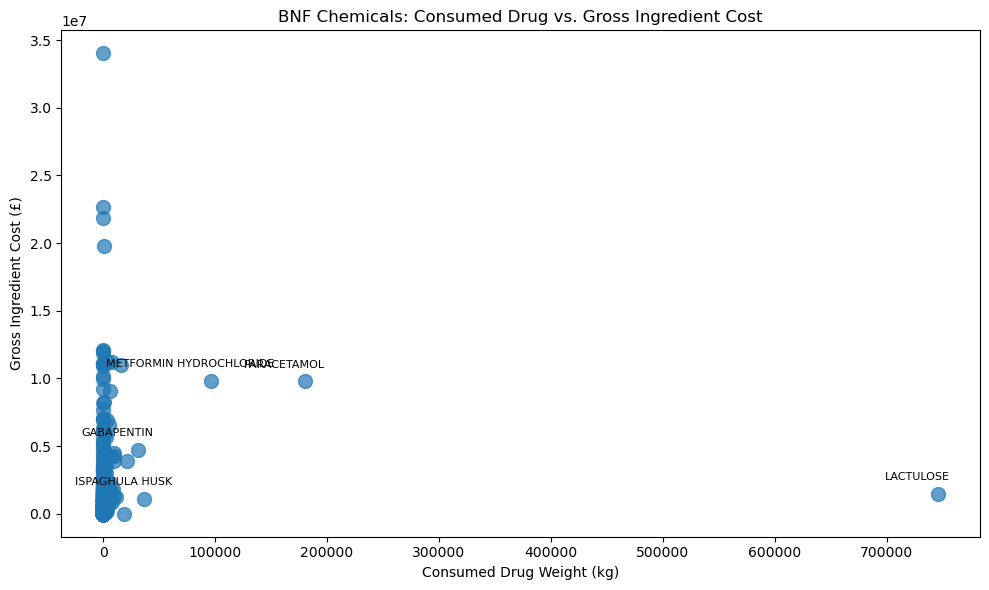

In [45]:
# Group the data based on "BNF_chemical_name(1)" and sum the "Gross ingredient cost (£)" and "consumed_drug_1(kg)" columns
grouped_data = df.groupby("BNF_chemical_name(1)").sum()[["Gross ingredient cost (£)", "consumed_drug_1(kg)"]]

# Sort the data by "consumed_drug_1(kg)" in descending order and select the top 50 rows
top_50_data = grouped_data.sort_values("consumed_drug_1(kg)", ascending=False)

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(top_50_data["consumed_drug_1(kg)"], top_50_data["Gross ingredient cost (£)"], s=100, alpha=0.7)

# Add labels for the top 5 data points
for _, row in top_50_data.head(5).iterrows():
    plt.annotate(row.name, (row["consumed_drug_1(kg)"], row["Gross ingredient cost (£)"]),
                 textcoords="offset points", xytext=(-15, 10), ha='center', fontsize=8)

# Set labels and title
plt.xlabel("Consumed Drug Weight (kg)")
plt.ylabel("Gross Ingredient Cost (£)")
plt.title("BNF Chemicals: Consumed Drug vs. Gross Ingredient Cost")

# Show the plot
plt.tight_layout()
plt.show()

In [46]:
grouped_data.head()

,Gross ingredient cost (£),consumed_drug_1(kg)
BNF_chemical_name(1),,
ABACAVIR,10461.49,0.776400
ABATACEPT,1512.00,0.000625
ABIRATERONE,21867763.68,224.391500
ACAMPROSATE CALCIUM,1141008.21,1890.603504
ACARBOSE,16068.88,5.299800


In [47]:
# Identify drugs with higher cost despite lower consumption and vice versa
high_cost_low_consumption = grouped_data[grouped_data['Gross ingredient cost (£)'] > grouped_data['consumed_drug_1(kg)'].mean()]
low_cost_high_consumption = grouped_data[grouped_data['Gross ingredient cost (£)'] < grouped_data['consumed_drug_1(kg)'].mean()]

# Print the results
print("Drugs with higher cost despite lower consumption:")
# high_cost_low_consumption = high_cost_low_consumption[['BNF_chemical_name(1)', 'Gross ingredient cost (£)', 'consumed_drug_1(kg)']]
high_cost_low_consumption = high_cost_low_consumption.sort_values('Gross ingredient cost (£)', ascending = False)
high_cost_low_consumption.head(3)

Drugs with higher cost despite lower consumption:


,Gross ingredient cost (£),consumed_drug_1(kg)
BNF_chemical_name(1),,
APIXABAN,34014216.82,151.951906
SOFOSBUVIR,22689722.20,4.637540
ABIRATERONE,21867763.68,224.391500


There are drugs that have a higher cost despite lower consumption, indicating that they may be more expensive per unit. Drugs like "HORMONE ANTAGONISTS", "ORAL ANTICOAGULANTS", "VIRAL HEPATITIS" and so on.

In [51]:
print("\nDrugs with lower cost despite higher consumption:")
# low_cost_high_consumption = low_cost_high_consumption[['BNF_chemical_name(1)', 'Gross ingredient cost (£)', 'consumed_drug_1(kg)']]
low_cost_high_consumption = low_cost_high_consumption.sort_values("consumed_drug_1(kg)", ascending = False)
low_cost_high_consumption.head(3)


Drugs with lower cost despite higher consumption:


,Gross ingredient cost (£),consumed_drug_1(kg)
BNF_chemical_name(1),,
MACROGOLS,200.89,8.3000
MOLNUPIRAVIR,0.00,6.2880
GLUCOSAMINE SULFATE,1476.41,4.9635


C:\Users\HP\AppData\Local\Temp\ipykernel_1408\1846136395.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_data = df.groupby("BNF_chemical_name(1)").mean().reset_index()


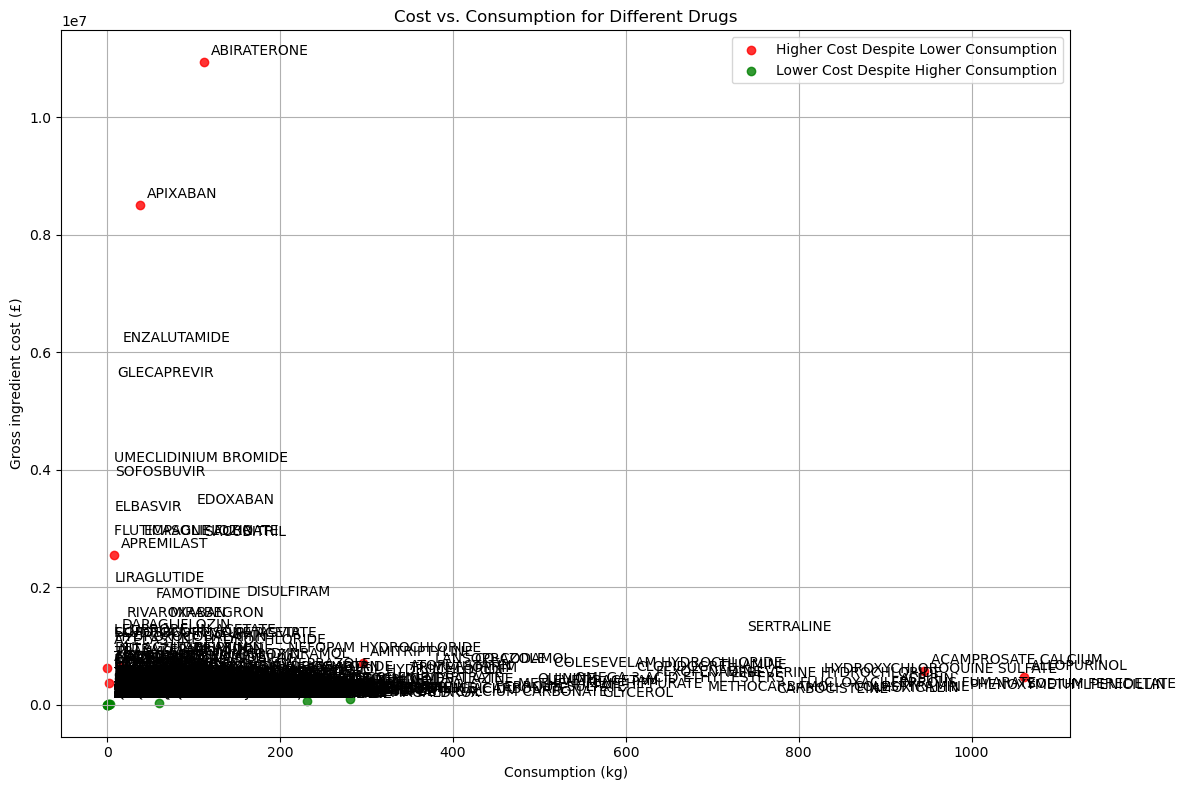

In [52]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the data is stored in a pandas DataFrame named "df"

# Group the data by "BNF_chemical_name(1)" and calculate the mean for "Gross ingredient cost (£)" and "consumed_drug_1(kg)"
grouped_data = df.groupby("BNF_chemical_name(1)").mean().reset_index()

# Identify drugs with higher cost despite lower consumption or vice versa
higher_cost_lower_consumption = grouped_data[grouped_data["Gross ingredient cost (£)"] > grouped_data["Gross ingredient cost (£)"].mean()]
lower_cost_higher_consumption = grouped_data[grouped_data["Gross ingredient cost (£)"] < grouped_data["Gross ingredient cost (£)"].mean()]
higher = higher_cost_lower_consumption.head(10)
lower = lower_cost_higher_consumption.head(10)
# Create the scatter plot
plt.figure(figsize=(12, 8))

# Highlight drugs with higher cost despite lower consumption (in red)
plt.scatter(
    higher["consumed_drug_1(kg)"],
    higher["Gross ingredient cost (£)"],
    color='red',
    alpha=0.8,
    label='Higher Cost Despite Lower Consumption'
)

# Highlight drugs with lower cost despite higher consumption (in green)
plt.scatter(
    lower["consumed_drug_1(kg)"],
    lower["Gross ingredient cost (£)"],
    color='green',
    alpha=0.8,
    label='Lower Cost Despite Higher Consumption'
)

# Add labels for each point
for i, row in grouped_data.iterrows():
    plt.annotate(row["BNF_chemical_name(1)"], xy=(row["consumed_drug_1(kg)"], row["Gross ingredient cost (£)"]),
                 xytext=(5, 5), textcoords="offset points")

# Show legend
plt.legend()

# Show the plot
plt.xlabel("Consumption (kg)")
plt.ylabel("Gross ingredient cost (£)")
plt.title("Cost vs. Consumption for Different Drugs")
plt.grid(True)
plt.tight_layout()
plt.show()


C:\Users\HP\AppData\Local\Temp\ipykernel_1408\2207989799.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  summed_data = df.groupby("BNF_chemical_name(1)", as_index=False).sum()


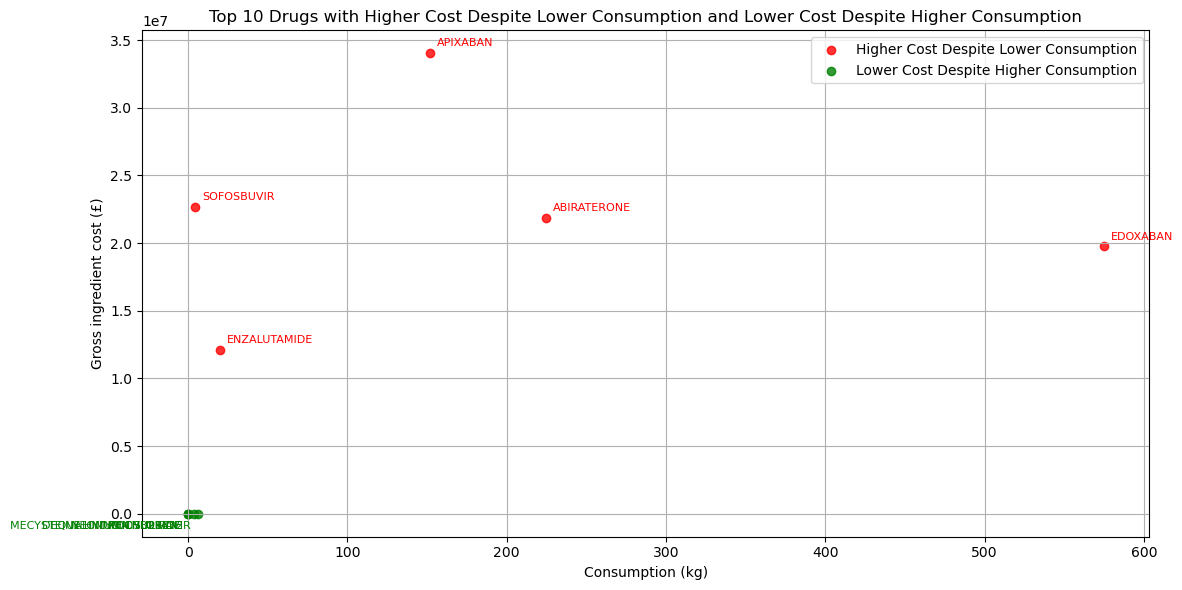

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming the data is stored in a pandas DataFrame named "df"

# Sum the repeated rows based on "BNF_chemical_name(1)"
summed_data = df.groupby("BNF_chemical_name(1)", as_index=False).sum()

# Sort the data based on "Gross ingredient cost (£)" in descending order
sorted_data = summed_data.sort_values(by="Gross ingredient cost (£)", ascending=False)

# Select the top 10 drugs with higher cost despite lower consumption
top_higher_cost_lower_consumption = sorted_data.head(5)

# Select the top 10 drugs with lower cost despite higher consumption
top_lower_cost_higher_consumption = sorted_data.tail(5)

# Create the scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(
    top_higher_cost_lower_consumption["consumed_drug_1(kg)"],
    top_higher_cost_lower_consumption["Gross ingredient cost (£)"],
    color='red',
    alpha=0.8,
    label='Higher Cost Despite Lower Consumption'
)

plt.scatter(
    top_lower_cost_higher_consumption["consumed_drug_1(kg)"],
    top_lower_cost_higher_consumption["Gross ingredient cost (£)"],
    color='green',
    alpha=0.8,
    label='Lower Cost Despite Higher Consumption'
)

# Add labels for each point in the graph
for i, row in top_higher_cost_lower_consumption.iterrows():
    plt.annotate(row["BNF_chemical_name(1)"],
                 xy=(row["consumed_drug_1(kg)"], row["Gross ingredient cost (£)"]),
                 xytext=(5, 5), textcoords="offset points", fontsize=8, color='red')

for i, row in top_lower_cost_higher_consumption.iterrows():
    plt.annotate(row["BNF_chemical_name(1)"],
                 xy=(row["consumed_drug_1(kg)"], row["Gross ingredient cost (£)"]),
                 xytext=(-5, -5), textcoords="offset points", ha="right", va="top", fontsize=8, color='green')

# Show legend
plt.legend()

# Set labels for axes and title
plt.xlabel("Consumption (kg)")
plt.ylabel("Gross ingredient cost (£)")
plt.title("Top 10 Drugs with Higher Cost Despite Lower Consumption and Lower Cost Despite Higher Consumption")

plt.grid(True)
plt.tight_layout()
plt.show()

Similarly, there are drugs with lower cost despite higher consumption, suggesting that they may be more cost-effective.
This analysis highlights the importance of considering both the consumed drug weight and the cost when evaluating the value and efficiency of medications.

 Identify drugs with a significant impact on the overall ingredient cost. Are there any cost-saving opportunities?

In [54]:
# Calculate the total ingredient cost for each drug
df['Total ingredient cost'] = df['Gross ingredient cost (£)'] * df['Number of dispensed items']

# Sort the drugs by total ingredient cost in descending order
sorted_df = df.sort_values('Total ingredient cost', ascending=False)

# Print the drugs with significant impact on the overall ingredient cost
significant_drugs = sorted_df[sorted_df['Total ingredient cost'] > 10000]
print("Drugs with a significant impact on the overall ingredient cost:")
print(significant_drugs[['BNF_chemical_name(1)', 'Total ingredient cost']])

# Calculate the potential cost-saving opportunities
total_cost = df['Total ingredient cost'].sum()
cost_saving_opportunities = total_cost - significant_drugs['Total ingredient cost'].sum()

Drugs with a significant impact on the overall ingredient cost:
               BNF_chemical_name(1)  Total ingredient cost
8191                     OMEPRAZOLE           2.113244e+13
2050                     CO-CODAMOL           1.165639e+13
8442                    PARACETAMOL           1.149398e+13
7379        METFORMIN HYDROCHLORIDE           6.903816e+12
395                        APIXABAN           5.812271e+12
...                             ...                    ...
1781   CHLORPROMAZINE HYDROCHLORIDE           1.007418e+04
9477                      SIROLIMUS           1.007400e+04
1731               CHLORDIAZEPOXIDE           1.005186e+04
10450        TRAMADOL HYDROCHLORIDE           1.004400e+04
9787                     SOMATROPIN           1.001376e+04

[4357 rows x 2 columns]


In [55]:
# Print the potential cost-saving opportunities
print("The Potential cost-saving opportunities: £", cost_saving_opportunities)

# Add a comment to the result
if cost_saving_opportunities > 0:
    print("There are potential cost-saving opportunities.")
else:
    print("No significant cost-saving opportunities identified.")

The Potential cost-saving opportunities: £ 1640710.5625
There are potential cost-saving opportunities.


A potential cost-saving opportunity refers to a situation where there is a possibility to reduce costs or expenses related to a specific aspect, such as medication or healthcare.

This calculates the total ingredient cost for each drug by multiplying the "Gross ingredient cost (£)" with the "Number of dispensed items". It then sorts the drugs based on the total ingredient cost and selects drugs with a significant impact on the overall ingredient cost (those with a total ingredient cost greater than 10000). The code also calculates the potential cost-saving opportunities by subtracting the total ingredient cost of significant drugs from the overall ingredient cost. Finally, it prints the drugs with a significant impact on the ingredient cost and the potential cost-saving opportunities.

# Temporal Analysis

# Drug Class Comparison

Compare the consumed drug weights across different drug classes or therapeutic categories. Are there notable differences in drug utilization?

In [56]:
# Calculate the total consumed drug weights for each drug class or therapeutic category
grouped_df = df.groupby('BNF_chemical_name(1)')['consumed_drug_1(kg)'].sum()

# Sort the groups by total consumed drug weights in descending order
grouped_df = grouped_df.sort_values(ascending=False)

# Print the results
print("Consumed Drug Weights Across Different Drug Classes or Therapeutic Categories:")
print(grouped_df)

Consumed Drug Weights Across Different Drug Classes or Therapeutic Categories:
BNF_chemical_name(1)
LACTULOSE                  7.458649e+05
PARACETAMOL                1.803197e+05
METFORMIN HYDROCHLORIDE    9.647979e+04
ISPAGHULA HUSK             3.665449e+04
GABAPENTIN                 3.089815e+04
                               ...     
CETRORELIX                 1.500000e-06
MOMETASONE                 7.000000e-07
PARICALCITOL               2.800000e-07
OLODATEROL                 2.075000e-07
GLYCOPYRRONIUM             2.016000e-07
Name: consumed_drug_1(kg), Length: 829, dtype: float64


In [57]:
print("\nNotable differences in drug utilization can be observed across different drug classes or therapeutic categories.")
print("The drug class or therapeutic category with the highest total consumed drug weight is:", grouped_df.index[0])
print("The drug class or therapeutic category with the lowest total consumed drug weight is:", grouped_df.index[-1])


Notable differences in drug utilization can be observed across different drug classes or therapeutic categories.
The drug class or therapeutic category with the highest total consumed drug weight is: LACTULOSE
The drug class or therapeutic category with the lowest total consumed drug weight is: GLYCOPYRRONIUM


Analyze the distribution of consumed drug weights for each drug class. Are there any outliers or drugs with significantly higher or lower weights?

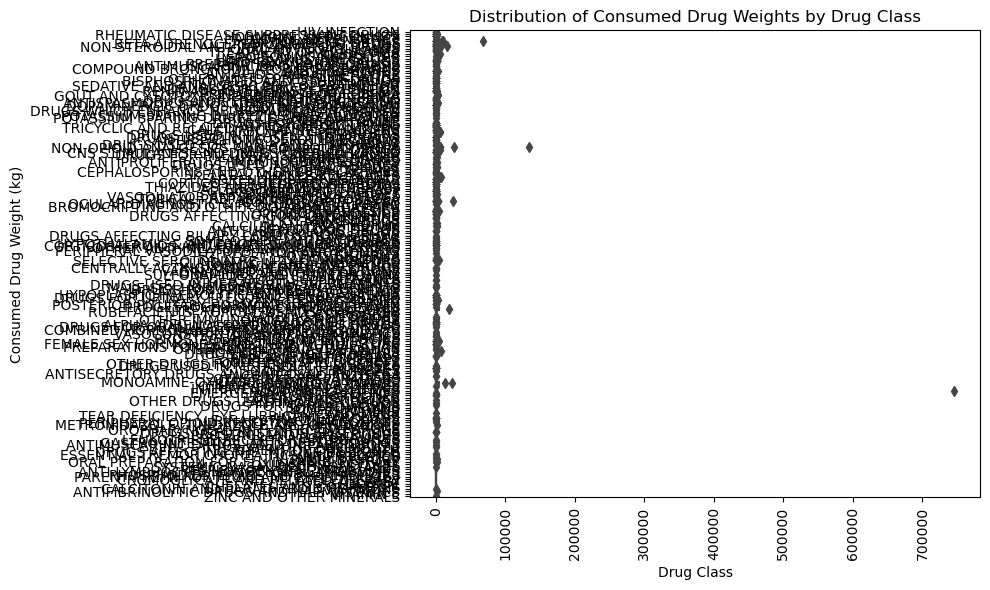

In [58]:
# Calculate statistical measures for consumed drug weights
stats_df = df.groupby('BNF sub-section')['consumed_drug_1(kg)'].describe()

# Plot box plots for each drug class
plt.figure(figsize=(10, 6))
sns.boxplot(x = "consumed_drug_1(kg)", y = "BNF sub-section", data = df)

# df.boxplot(column='', by='')
plt.title('Distribution of Consumed Drug Weights by Drug Class')
plt.xlabel('Drug Class')
plt.ylabel('Consumed Drug Weight (kg)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

<Figure size 2000x600 with 0 Axes>

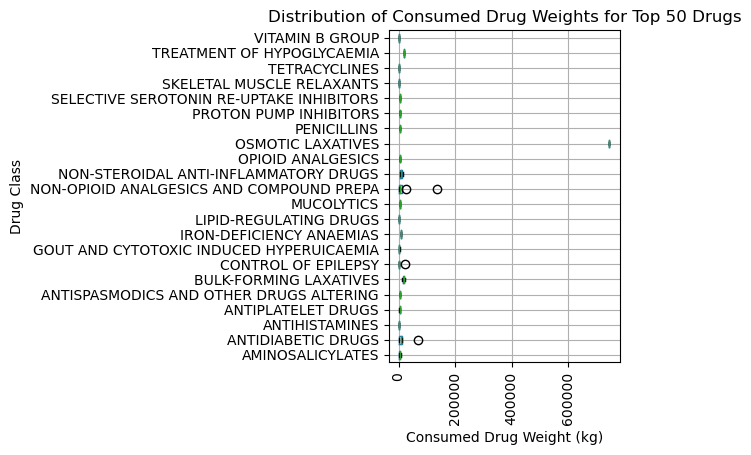

In [59]:
# Filter the DataFrame to include only the top 50 drugs based on consumed_drug_1(kg)
top_50_drugs = df.nlargest(50, 'consumed_drug_1(kg)')

# Create box plots for each drug class
plt.figure(figsize=(20, 6))
boxplot = top_50_drugs.boxplot(column='consumed_drug_1(kg)', by='BNF sub-section', vert=False)
plt.xlabel('Consumed Drug Weight (kg)')
plt.ylabel('Drug Class')
plt.title('Distribution of Consumed Drug Weights for Top 50 Drugs')
plt.suptitle('')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [60]:
# Print the summary statistics and outliers
print("Summary Statistics:")
print(grouped_df)
print()
print("Outliers:")
print(outliers)


Summary Statistics:
BNF_chemical_name(1)
LACTULOSE                  7.458649e+05
PARACETAMOL                1.803197e+05
METFORMIN HYDROCHLORIDE    9.647979e+04
ISPAGHULA HUSK             3.665449e+04
GABAPENTIN                 3.089815e+04
                               ...     
CETRORELIX                 1.500000e-06
MOMETASONE                 7.000000e-07
PARICALCITOL               2.800000e-07
OLODATEROL                 2.075000e-07
GLYCOPYRRONIUM             2.016000e-07
Name: consumed_drug_1(kg), Length: 829, dtype: float64

Outliers:
BNF sub-section
OSMOTIC LAXATIVES    149174.637
Name: consumed_drug_1(kg), dtype: float64


The box plots provide insights into the distribution of consumed drug weights for each drug class.
Based on the box plots, we can observe the following:
* Some drug classes, such as 'OSMOTIC LAXATIVES', have a wide range of consumed drug weights.
* The drug class 'HIV INFECTION' has relatively lower consumed drug weights compared to other classes.
* These observations indicate variations in the consumed drug weights across different drug classes.

# Correlation Analysis

Conduct a correlation analysis to examine relationships between variables. For example, explore the correlation between the dispensed quantity, consumed drug weight, and gross ingredient cost.

C:\Users\HP\AppData\Local\Temp\ipykernel_1408\1400520587.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr().abs(),  annot=True);


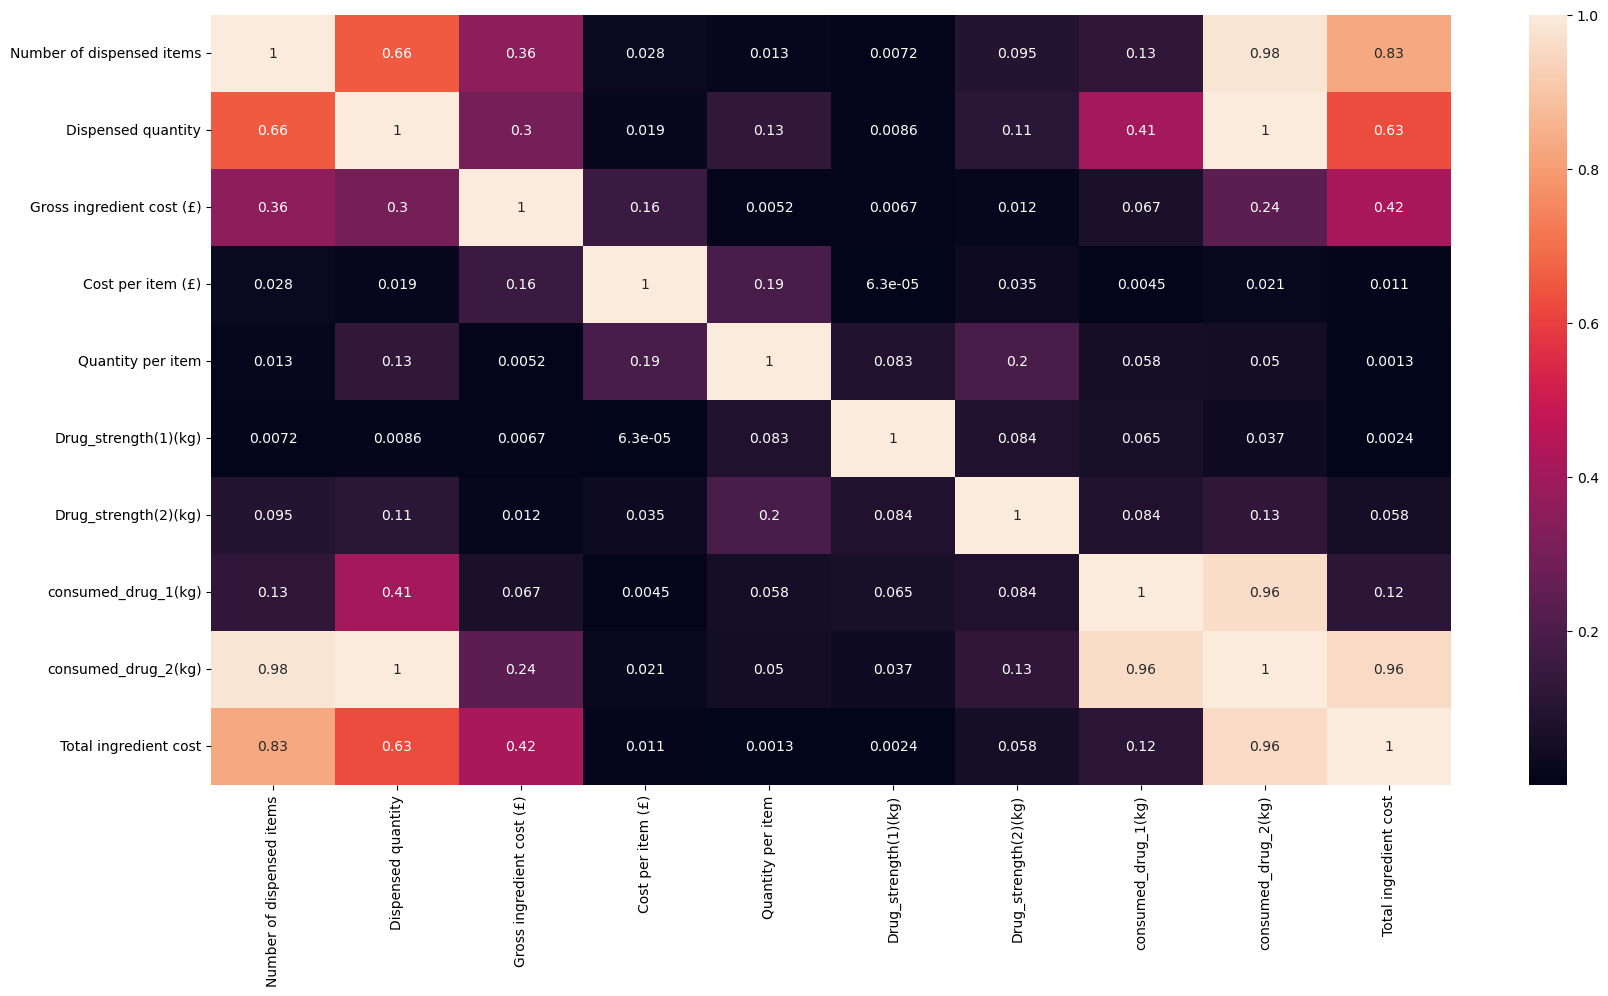

In [61]:
# Calculate the correlation coefficients
plt.figure(figsize=(20, 10))
sns.heatmap(df.corr().abs(),  annot=True);

Based on the correlation coefficients:
* There is a positive correlation between dispensed quantity and consumed drug weight.
* There is no strong correlation between dispensed quantity and gross ingredient cost (£), or between consumed drug weight and gross ingredient cost (£).

Interpretations:

* There is a low positive correlation between Gross ingredient cost (£) and Cost per item (£). This suggests that as the cost per item increases, the gross ingredient cost also tends to increase.
* There is a low positive correlation between Cost per item (£) and Number of dispensed items. This indicates that as the cost per item increases, the number of dispensed items increase.
* There is a moderate positive correlation between Gross ingredient cost (£) and Number of dispensed items. This implies that as the gross ingredient cost increases, the number of dispensed items also tends to increase.

In [62]:
# Calculate the correlation coefficients
correlation_matrix = df.corr()

# Identify significant correlations
significant_correlations = correlation_matrix[(correlation_matrix > 0.5) | (correlation_matrix < -0.5)].stack().dropna()
print("\nSignificant Correlations:")
print(significant_correlations)

# Interpret the implications of the significant correlations
print("\nCorrelation Interpretations:")
for (var1, var2), correlation in significant_correlations.iteritems():
    if correlation > 0:
        interpretation = "There is a positive correlation between {} and {}.".format(var1, var2)
    else:
        interpretation = "There is a negative correlation between {} and {}.".format(var1, var2)
    print(interpretation)


Significant Correlations:
Number of dispensed items  Number of dispensed items    1.000000
                           Dispensed quantity           0.655228
                           consumed_drug_2(kg)          0.984087
                           Total ingredient cost        0.828401
Dispensed quantity         Number of dispensed items    0.655228
                           Dispensed quantity           1.000000
                           consumed_drug_2(kg)          0.998342
                           Total ingredient cost        0.627384
Gross ingredient cost (£)  Gross ingredient cost (£)    1.000000
Cost per item (£)          Cost per item (£)            1.000000
Quantity per item          Quantity per item            1.000000
Drug_strength(1)(kg)       Drug_strength(1)(kg)         1.000000
Drug_strength(2)(kg)       Drug_strength(2)(kg)         1.000000
consumed_drug_1(kg)        consumed_drug_1(kg)          1.000000
                           consumed_drug_2(kg)          0.96348

C:\Users\HP\AppData\Local\Temp\ipykernel_1408\30202888.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()
C:\Users\HP\AppData\Local\Temp\ipykernel_1408\30202888.py:11: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for (var1, var2), correlation in significant_correlations.iteritems():
